In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_t1_mask_t1t2_normalized_k5_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 184)
(4629816, 8)
validation
(621056, 184)
(621056, 8)
test
(624904, 184)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 184)]             0         


 dense (Dense)               (None, 1024)              189440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 879496 (3.36 MB)


Trainable params: 879496 (3.36 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/463 [..............................] - ETA: 10:01 - loss: 2.2856 - STD: 0.0636 - MAE: 0.2204

  6/463 [..............................] - ETA: 4s - loss: 2.1194 - STD: 0.0541 - MAE: 0.2167   

 11/463 [..............................] - ETA: 4s - loss: 2.0970 - STD: 0.0494 - MAE: 0.2165

 16/463 [>.............................] - ETA: 4s - loss: 2.0852 - STD: 0.0426 - MAE: 0.2167

 21/463 [>.............................] - ETA: 4s - loss: 2.0790 - STD: 0.0398 - MAE: 0.2168

 26/463 [>.............................] - ETA: 4s - loss: 2.0740 - STD: 0.0385 - MAE: 0.2168

 32/463 [=>............................] - ETA: 4s - loss: 2.0702 - STD: 0.0381 - MAE: 0.2167

 38/463 [=>............................] - ETA: 4s - loss: 2.0674 - STD: 0.0369 - MAE: 0.2167

 43/463 [=>............................] - ETA: 4s - loss: 2.0656 - STD: 0.0363 - MAE: 0.2167

 49/463 [==>...........................] - ETA: 4s - loss: 2.0638 - STD: 0.0358 - MAE: 0.2167

 55/463 [==>...........................] - ETA: 4s - loss: 2.0626 - STD: 0.0355 - MAE: 0.2167

 61/463 [==>...........................] - ETA: 4s - loss: 2.0617 - STD: 0.0348 - MAE: 0.2168

 67/463 [===>..........................] - ETA: 3s - loss: 2.0608 - STD: 0.0346 - MAE: 0.2167

 73/463 [===>..........................] - ETA: 3s - loss: 2.0599 - STD: 0.0344 - MAE: 0.2167

 78/463 [====>.........................] - ETA: 3s - loss: 2.0592 - STD: 0.0342 - MAE: 0.2167

 83/463 [====>.........................] - ETA: 3s - loss: 2.0586 - STD: 0.0342 - MAE: 0.2167

 89/463 [====>.........................] - ETA: 3s - loss: 2.0581 - STD: 0.0338 - MAE: 0.2167

 95/463 [=====>........................] - ETA: 3s - loss: 2.0573 - STD: 0.0338 - MAE: 0.2167

101/463 [=====>........................] - ETA: 3s - loss: 2.0563 - STD: 0.0337 - MAE: 0.2167

107/463 [=====>........................] - ETA: 3s - loss: 2.0550 - STD: 0.0337 - MAE: 0.2167

113/463 [======>.......................] - ETA: 3s - loss: 2.0529 - STD: 0.0337 - MAE: 0.2166

119/463 [======>.......................] - ETA: 3s - loss: 2.0493 - STD: 0.0339 - MAE: 0.2165

125/463 [=======>......................] - ETA: 3s - loss: 2.0440 - STD: 0.0347 - MAE: 0.2162

131/463 [=======>......................] - ETA: 3s - loss: 2.0372 - STD: 0.0359 - MAE: 0.2159

137/463 [=======>......................] - ETA: 3s - loss: 2.0294 - STD: 0.0375 - MAE: 0.2155

143/463 [========>.....................] - ETA: 3s - loss: 2.0212 - STD: 0.0393 - MAE: 0.2150

149/463 [========>.....................] - ETA: 3s - loss: 2.0134 - STD: 0.0412 - MAE: 0.2146

155/463 [=========>....................] - ETA: 3s - loss: 2.0057 - STD: 0.0430 - MAE: 0.2141

161/463 [=========>....................] - ETA: 2s - loss: 1.9983 - STD: 0.0447 - MAE: 0.2136

165/463 [=========>....................] - ETA: 4s - loss: 1.9936 - STD: 0.0458 - MAE: 0.2134

171/463 [==========>...................] - ETA: 4s - loss: 1.9865 - STD: 0.0474 - MAE: 0.2129

176/463 [==========>...................] - ETA: 4s - loss: 1.9810 - STD: 0.0487 - MAE: 0.2126

181/463 [==========>...................] - ETA: 3s - loss: 1.9759 - STD: 0.0499 - MAE: 0.2123

187/463 [===========>..................] - ETA: 3s - loss: 1.9698 - STD: 0.0512 - MAE: 0.2119

192/463 [===========>..................] - ETA: 3s - loss: 1.9648 - STD: 0.0524 - MAE: 0.2116

198/463 [===========>..................] - ETA: 3s - loss: 1.9591 - STD: 0.0536 - MAE: 0.2113

204/463 [============>.................] - ETA: 3s - loss: 1.9536 - STD: 0.0548 - MAE: 0.2109

210/463 [============>.................] - ETA: 3s - loss: 1.9485 - STD: 0.0560 - MAE: 0.2106

215/463 [============>.................] - ETA: 3s - loss: 1.9442 - STD: 0.0569 - MAE: 0.2103

221/463 [=============>................] - ETA: 3s - loss: 1.9391 - STD: 0.0580 - MAE: 0.2100

227/463 [=============>................] - ETA: 3s - loss: 1.9344 - STD: 0.0591 - MAE: 0.2097

233/463 [==============>...............] - ETA: 2s - loss: 1.9296 - STD: 0.0602 - MAE: 0.2094

239/463 [==============>...............] - ETA: 2s - loss: 1.9251 - STD: 0.0612 - MAE: 0.2091

245/463 [==============>...............] - ETA: 2s - loss: 1.9207 - STD: 0.0621 - MAE: 0.2088

251/463 [===============>..............] - ETA: 2s - loss: 1.9165 - STD: 0.0631 - MAE: 0.2086

257/463 [===============>..............] - ETA: 2s - loss: 1.9126 - STD: 0.0640 - MAE: 0.2083

263/463 [================>.............] - ETA: 2s - loss: 1.9087 - STD: 0.0649 - MAE: 0.2081

269/463 [================>.............] - ETA: 2s - loss: 1.9049 - STD: 0.0657 - MAE: 0.2078

274/463 [================>.............] - ETA: 2s - loss: 1.9019 - STD: 0.0664 - MAE: 0.2076

280/463 [=================>............] - ETA: 2s - loss: 1.8983 - STD: 0.0672 - MAE: 0.2074

286/463 [=================>............] - ETA: 2s - loss: 1.8947 - STD: 0.0680 - MAE: 0.2071

292/463 [=================>............] - ETA: 2s - loss: 1.8911 - STD: 0.0687 - MAE: 0.2069

298/463 [==================>...........] - ETA: 2s - loss: 1.8876 - STD: 0.0695 - MAE: 0.2067

304/463 [==================>...........] - ETA: 1s - loss: 1.8842 - STD: 0.0702 - MAE: 0.2065

310/463 [===================>..........] - ETA: 1s - loss: 1.8809 - STD: 0.0709 - MAE: 0.2062

316/463 [===================>..........] - ETA: 1s - loss: 1.8778 - STD: 0.0717 - MAE: 0.2060

322/463 [===================>..........] - ETA: 1s - loss: 1.8747 - STD: 0.0723 - MAE: 0.2058

328/463 [====================>.........] - ETA: 1s - loss: 1.8716 - STD: 0.0730 - MAE: 0.2056

334/463 [====================>.........] - ETA: 1s - loss: 1.8685 - STD: 0.0736 - MAE: 0.2054

340/463 [=====================>........] - ETA: 1s - loss: 1.8657 - STD: 0.0743 - MAE: 0.2052

346/463 [=====================>........] - ETA: 1s - loss: 1.8627 - STD: 0.0749 - MAE: 0.2050

352/463 [=====================>........] - ETA: 1s - loss: 1.8599 - STD: 0.0755 - MAE: 0.2048

358/463 [======================>.......] - ETA: 1s - loss: 1.8570 - STD: 0.0762 - MAE: 0.2046

364/463 [======================>.......] - ETA: 1s - loss: 1.8543 - STD: 0.0768 - MAE: 0.2044

370/463 [======================>.......] - ETA: 1s - loss: 1.8517 - STD: 0.0774 - MAE: 0.2042

376/463 [=======================>......] - ETA: 1s - loss: 1.8492 - STD: 0.0779 - MAE: 0.2041

381/463 [=======================>......] - ETA: 0s - loss: 1.8471 - STD: 0.0784 - MAE: 0.2039

387/463 [========================>.....] - ETA: 0s - loss: 1.8447 - STD: 0.0789 - MAE: 0.2037

393/463 [========================>.....] - ETA: 0s - loss: 1.8424 - STD: 0.0794 - MAE: 0.2036

399/463 [========================>.....] - ETA: 0s - loss: 1.8400 - STD: 0.0799 - MAE: 0.2034

405/463 [=========================>....] - ETA: 0s - loss: 1.8377 - STD: 0.0804 - MAE: 0.2033

411/463 [=========================>....] - ETA: 0s - loss: 1.8354 - STD: 0.0809 - MAE: 0.2031

412/463 [=========================>....] - ETA: 0s - loss: 1.8351 - STD: 0.0809 - MAE: 0.2031

418/463 [==========================>...] - ETA: 0s - loss: 1.8329 - STD: 0.0814 - MAE: 0.2029

424/463 [==========================>...] - ETA: 0s - loss: 1.8307 - STD: 0.0819 - MAE: 0.2028

430/463 [==========================>...] - ETA: 0s - loss: 1.8285 - STD: 0.0823 - MAE: 0.2026

436/463 [===========================>..] - ETA: 0s - loss: 1.8264 - STD: 0.0828 - MAE: 0.2025

442/463 [===========================>..] - ETA: 0s - loss: 1.8243 - STD: 0.0832 - MAE: 0.2023

448/463 [============================>.] - ETA: 0s - loss: 1.8222 - STD: 0.0836 - MAE: 0.2022

454/463 [============================>.] - ETA: 0s - loss: 1.8203 - STD: 0.0841 - MAE: 0.2021

460/463 [============================>.] - ETA: 0s - loss: 1.8183 - STD: 0.0845 - MAE: 0.2019

463/463 [==============================] - 7s 13ms/step - loss: 1.8174 - STD: 0.0847 - MAE: 0.2019 - val_loss: 1.8021 - val_STD: 0.1122 - val_MAE: 0.1952


Epoch 2/10000


  1/463 [..............................] - ETA: 14s - loss: 1.6699 - STD: 0.1126 - MAE: 0.1921

  6/463 [..............................] - ETA: 4s - loss: 1.6750 - STD: 0.1147 - MAE: 0.1921 

 11/463 [..............................] - ETA: 4s - loss: 1.6733 - STD: 0.1155 - MAE: 0.1918

 17/463 [>.............................] - ETA: 4s - loss: 1.6743 - STD: 0.1154 - MAE: 0.1919

 23/463 [>.............................] - ETA: 4s - loss: 1.6742 - STD: 0.1152 - MAE: 0.1919

 29/463 [>.............................] - ETA: 4s - loss: 1.6736 - STD: 0.1152 - MAE: 0.1919

 34/463 [=>............................] - ETA: 4s - loss: 1.6731 - STD: 0.1151 - MAE: 0.1919

 39/463 [=>............................] - ETA: 4s - loss: 1.6716 - STD: 0.1154 - MAE: 0.1918

 45/463 [=>............................] - ETA: 4s - loss: 1.6706 - STD: 0.1155 - MAE: 0.1917

 51/463 [==>...........................] - ETA: 4s - loss: 1.6702 - STD: 0.1155 - MAE: 0.1917

 56/463 [==>...........................] - ETA: 4s - loss: 1.6695 - STD: 0.1156 - MAE: 0.1916

 62/463 [===>..........................] - ETA: 3s - loss: 1.6688 - STD: 0.1156 - MAE: 0.1916

 68/463 [===>..........................] - ETA: 3s - loss: 1.6687 - STD: 0.1156 - MAE: 0.1916

 74/463 [===>..........................] - ETA: 3s - loss: 1.6685 - STD: 0.1157 - MAE: 0.1916

 80/463 [====>.........................] - ETA: 3s - loss: 1.6682 - STD: 0.1157 - MAE: 0.1916

 86/463 [====>.........................] - ETA: 3s - loss: 1.6677 - STD: 0.1159 - MAE: 0.1915

 92/463 [====>.........................] - ETA: 3s - loss: 1.6671 - STD: 0.1160 - MAE: 0.1915

 98/463 [=====>........................] - ETA: 3s - loss: 1.6666 - STD: 0.1160 - MAE: 0.1914

104/463 [=====>........................] - ETA: 3s - loss: 1.6664 - STD: 0.1160 - MAE: 0.1914

110/463 [======>.......................] - ETA: 3s - loss: 1.6662 - STD: 0.1161 - MAE: 0.1914

115/463 [======>.......................] - ETA: 3s - loss: 1.6658 - STD: 0.1161 - MAE: 0.1914

121/463 [======>.......................] - ETA: 3s - loss: 1.6653 - STD: 0.1162 - MAE: 0.1913

127/463 [=======>......................] - ETA: 3s - loss: 1.6649 - STD: 0.1162 - MAE: 0.1913

133/463 [=======>......................] - ETA: 3s - loss: 1.6643 - STD: 0.1163 - MAE: 0.1913

139/463 [========>.....................] - ETA: 3s - loss: 1.6638 - STD: 0.1164 - MAE: 0.1912

145/463 [========>.....................] - ETA: 3s - loss: 1.6630 - STD: 0.1164 - MAE: 0.1912

151/463 [========>.....................] - ETA: 3s - loss: 1.6625 - STD: 0.1165 - MAE: 0.1911

157/463 [=========>....................] - ETA: 3s - loss: 1.6620 - STD: 0.1166 - MAE: 0.1911

163/463 [=========>....................] - ETA: 2s - loss: 1.6617 - STD: 0.1167 - MAE: 0.1911

168/463 [=========>....................] - ETA: 2s - loss: 1.6614 - STD: 0.1167 - MAE: 0.1911

173/463 [==========>...................] - ETA: 2s - loss: 1.6612 - STD: 0.1168 - MAE: 0.1910

179/463 [==========>...................] - ETA: 2s - loss: 1.6609 - STD: 0.1169 - MAE: 0.1910

185/463 [==========>...................] - ETA: 2s - loss: 1.6606 - STD: 0.1169 - MAE: 0.1910

191/463 [===========>..................] - ETA: 2s - loss: 1.6602 - STD: 0.1169 - MAE: 0.1910

197/463 [===========>..................] - ETA: 2s - loss: 1.6599 - STD: 0.1170 - MAE: 0.1909

202/463 [============>.................] - ETA: 2s - loss: 1.6597 - STD: 0.1171 - MAE: 0.1909

207/463 [============>.................] - ETA: 2s - loss: 1.6592 - STD: 0.1171 - MAE: 0.1909

213/463 [============>.................] - ETA: 2s - loss: 1.6588 - STD: 0.1172 - MAE: 0.1909

219/463 [=============>................] - ETA: 2s - loss: 1.6582 - STD: 0.1172 - MAE: 0.1908

225/463 [=============>................] - ETA: 2s - loss: 1.6579 - STD: 0.1173 - MAE: 0.1908

230/463 [=============>................] - ETA: 2s - loss: 1.6576 - STD: 0.1173 - MAE: 0.1908

236/463 [==============>...............] - ETA: 2s - loss: 1.6572 - STD: 0.1174 - MAE: 0.1907

242/463 [==============>...............] - ETA: 2s - loss: 1.6567 - STD: 0.1175 - MAE: 0.1907

248/463 [===============>..............] - ETA: 2s - loss: 1.6563 - STD: 0.1176 - MAE: 0.1907

254/463 [===============>..............] - ETA: 2s - loss: 1.6560 - STD: 0.1176 - MAE: 0.1907

260/463 [===============>..............] - ETA: 1s - loss: 1.6555 - STD: 0.1177 - MAE: 0.1906

266/463 [================>.............] - ETA: 1s - loss: 1.6551 - STD: 0.1177 - MAE: 0.1906

272/463 [================>.............] - ETA: 1s - loss: 1.6547 - STD: 0.1178 - MAE: 0.1906

278/463 [=================>............] - ETA: 1s - loss: 1.6544 - STD: 0.1178 - MAE: 0.1905

284/463 [=================>............] - ETA: 1s - loss: 1.6540 - STD: 0.1179 - MAE: 0.1905

290/463 [=================>............] - ETA: 1s - loss: 1.6538 - STD: 0.1179 - MAE: 0.1905

296/463 [==================>...........] - ETA: 1s - loss: 1.6535 - STD: 0.1180 - MAE: 0.1905

302/463 [==================>...........] - ETA: 1s - loss: 1.6530 - STD: 0.1180 - MAE: 0.1904

308/463 [==================>...........] - ETA: 1s - loss: 1.6527 - STD: 0.1181 - MAE: 0.1904

314/463 [===================>..........] - ETA: 1s - loss: 1.6524 - STD: 0.1182 - MAE: 0.1904

320/463 [===================>..........] - ETA: 1s - loss: 1.6520 - STD: 0.1182 - MAE: 0.1904

326/463 [====================>.........] - ETA: 1s - loss: 1.6518 - STD: 0.1182 - MAE: 0.1903

331/463 [====================>.........] - ETA: 1s - loss: 1.6517 - STD: 0.1183 - MAE: 0.1903

337/463 [====================>.........] - ETA: 1s - loss: 1.6514 - STD: 0.1183 - MAE: 0.1903

342/463 [=====================>........] - ETA: 1s - loss: 1.6512 - STD: 0.1184 - MAE: 0.1903

347/463 [=====================>........] - ETA: 1s - loss: 1.6511 - STD: 0.1184 - MAE: 0.1903

353/463 [=====================>........] - ETA: 1s - loss: 1.6508 - STD: 0.1184 - MAE: 0.1903

359/463 [======================>.......] - ETA: 1s - loss: 1.6505 - STD: 0.1185 - MAE: 0.1902

364/463 [======================>.......] - ETA: 0s - loss: 1.6501 - STD: 0.1185 - MAE: 0.1902

370/463 [======================>.......] - ETA: 0s - loss: 1.6499 - STD: 0.1186 - MAE: 0.1902

376/463 [=======================>......] - ETA: 0s - loss: 1.6497 - STD: 0.1186 - MAE: 0.1902

382/463 [=======================>......] - ETA: 0s - loss: 1.6494 - STD: 0.1187 - MAE: 0.1901

388/463 [========================>.....] - ETA: 0s - loss: 1.6491 - STD: 0.1187 - MAE: 0.1901

394/463 [========================>.....] - ETA: 0s - loss: 1.6489 - STD: 0.1188 - MAE: 0.1901

400/463 [========================>.....] - ETA: 0s - loss: 1.6485 - STD: 0.1188 - MAE: 0.1901

406/463 [=========================>....] - ETA: 0s - loss: 1.6482 - STD: 0.1189 - MAE: 0.1901

412/463 [=========================>....] - ETA: 0s - loss: 1.6478 - STD: 0.1189 - MAE: 0.1900

418/463 [==========================>...] - ETA: 0s - loss: 1.6476 - STD: 0.1190 - MAE: 0.1900

424/463 [==========================>...] - ETA: 0s - loss: 1.6473 - STD: 0.1190 - MAE: 0.1900

430/463 [==========================>...] - ETA: 0s - loss: 1.6471 - STD: 0.1190 - MAE: 0.1900

436/463 [===========================>..] - ETA: 0s - loss: 1.6467 - STD: 0.1191 - MAE: 0.1899

442/463 [===========================>..] - ETA: 0s - loss: 1.6465 - STD: 0.1191 - MAE: 0.1899

448/463 [============================>.] - ETA: 0s - loss: 1.6465 - STD: 0.1192 - MAE: 0.1899

454/463 [============================>.] - ETA: 0s - loss: 1.6463 - STD: 0.1192 - MAE: 0.1899

460/463 [============================>.] - ETA: 0s - loss: 1.6462 - STD: 0.1192 - MAE: 0.1899

463/463 [==============================] - 5s 11ms/step - loss: 1.6461 - STD: 0.1193 - MAE: 0.1899 - val_loss: 1.7915 - val_STD: 0.1168 - val_MAE: 0.1936


Epoch 3/10000


  1/463 [..............................] - ETA: 14s - loss: 1.6279 - STD: 0.1197 - MAE: 0.1890

  6/463 [..............................] - ETA: 4s - loss: 1.6282 - STD: 0.1217 - MAE: 0.1887 

 12/463 [..............................] - ETA: 4s - loss: 1.6285 - STD: 0.1220 - MAE: 0.1886

 17/463 [>.............................] - ETA: 4s - loss: 1.6265 - STD: 0.1216 - MAE: 0.1886

 23/463 [>.............................] - ETA: 4s - loss: 1.6258 - STD: 0.1219 - MAE: 0.1885

 29/463 [>.............................] - ETA: 4s - loss: 1.6271 - STD: 0.1222 - MAE: 0.1885

 35/463 [=>............................] - ETA: 4s - loss: 1.6276 - STD: 0.1223 - MAE: 0.1885

 41/463 [=>............................] - ETA: 4s - loss: 1.6281 - STD: 0.1223 - MAE: 0.1885

 46/463 [=>............................] - ETA: 4s - loss: 1.6277 - STD: 0.1222 - MAE: 0.1885

 52/463 [==>...........................] - ETA: 4s - loss: 1.6274 - STD: 0.1222 - MAE: 0.1885

 58/463 [==>...........................] - ETA: 3s - loss: 1.6275 - STD: 0.1222 - MAE: 0.1885

 64/463 [===>..........................] - ETA: 3s - loss: 1.6268 - STD: 0.1222 - MAE: 0.1885

 70/463 [===>..........................] - ETA: 3s - loss: 1.6256 - STD: 0.1225 - MAE: 0.1883

 76/463 [===>..........................] - ETA: 3s - loss: 1.6256 - STD: 0.1225 - MAE: 0.1883

 82/463 [====>.........................] - ETA: 3s - loss: 1.6249 - STD: 0.1226 - MAE: 0.1883

 88/463 [====>.........................] - ETA: 3s - loss: 1.6251 - STD: 0.1225 - MAE: 0.1883

 93/463 [=====>........................] - ETA: 3s - loss: 1.6250 - STD: 0.1226 - MAE: 0.1883

 98/463 [=====>........................] - ETA: 3s - loss: 1.6248 - STD: 0.1226 - MAE: 0.1883

104/463 [=====>........................] - ETA: 3s - loss: 1.6247 - STD: 0.1227 - MAE: 0.1883

110/463 [======>.......................] - ETA: 3s - loss: 1.6246 - STD: 0.1227 - MAE: 0.1883

116/463 [======>.......................] - ETA: 3s - loss: 1.6243 - STD: 0.1227 - MAE: 0.1882

122/463 [======>.......................] - ETA: 3s - loss: 1.6240 - STD: 0.1228 - MAE: 0.1882

128/463 [=======>......................] - ETA: 3s - loss: 1.6236 - STD: 0.1228 - MAE: 0.1882

134/463 [=======>......................] - ETA: 3s - loss: 1.6233 - STD: 0.1229 - MAE: 0.1882

140/463 [========>.....................] - ETA: 3s - loss: 1.6229 - STD: 0.1229 - MAE: 0.1881

146/463 [========>.....................] - ETA: 3s - loss: 1.6225 - STD: 0.1230 - MAE: 0.1881

152/463 [========>.....................] - ETA: 3s - loss: 1.6221 - STD: 0.1231 - MAE: 0.1881

158/463 [=========>....................] - ETA: 2s - loss: 1.6219 - STD: 0.1231 - MAE: 0.1880

164/463 [=========>....................] - ETA: 2s - loss: 1.6219 - STD: 0.1232 - MAE: 0.1880

170/463 [==========>...................] - ETA: 2s - loss: 1.6218 - STD: 0.1232 - MAE: 0.1880

176/463 [==========>...................] - ETA: 2s - loss: 1.6218 - STD: 0.1232 - MAE: 0.1880

182/463 [==========>...................] - ETA: 2s - loss: 1.6216 - STD: 0.1232 - MAE: 0.1880

188/463 [===========>..................] - ETA: 2s - loss: 1.6213 - STD: 0.1232 - MAE: 0.1880

194/463 [===========>..................] - ETA: 2s - loss: 1.6212 - STD: 0.1233 - MAE: 0.1880

200/463 [===========>..................] - ETA: 2s - loss: 1.6211 - STD: 0.1233 - MAE: 0.1880

206/463 [============>.................] - ETA: 2s - loss: 1.6209 - STD: 0.1233 - MAE: 0.1880

211/463 [============>.................] - ETA: 2s - loss: 1.6209 - STD: 0.1233 - MAE: 0.1880

217/463 [=============>................] - ETA: 2s - loss: 1.6207 - STD: 0.1234 - MAE: 0.1879

223/463 [=============>................] - ETA: 2s - loss: 1.6206 - STD: 0.1234 - MAE: 0.1879

229/463 [=============>................] - ETA: 2s - loss: 1.6203 - STD: 0.1234 - MAE: 0.1879

235/463 [==============>...............] - ETA: 2s - loss: 1.6201 - STD: 0.1235 - MAE: 0.1879

241/463 [==============>...............] - ETA: 2s - loss: 1.6199 - STD: 0.1235 - MAE: 0.1879

247/463 [===============>..............] - ETA: 2s - loss: 1.6198 - STD: 0.1235 - MAE: 0.1879

253/463 [===============>..............] - ETA: 2s - loss: 1.6197 - STD: 0.1235 - MAE: 0.1879

259/463 [===============>..............] - ETA: 1s - loss: 1.6197 - STD: 0.1236 - MAE: 0.1879

265/463 [================>.............] - ETA: 1s - loss: 1.6196 - STD: 0.1236 - MAE: 0.1879

271/463 [================>.............] - ETA: 1s - loss: 1.6194 - STD: 0.1236 - MAE: 0.1878

277/463 [================>.............] - ETA: 1s - loss: 1.6193 - STD: 0.1236 - MAE: 0.1878

282/463 [=================>............] - ETA: 1s - loss: 1.6193 - STD: 0.1236 - MAE: 0.1878

288/463 [=================>............] - ETA: 1s - loss: 1.6193 - STD: 0.1237 - MAE: 0.1878

293/463 [=================>............] - ETA: 1s - loss: 1.6191 - STD: 0.1237 - MAE: 0.1878

298/463 [==================>...........] - ETA: 1s - loss: 1.6191 - STD: 0.1237 - MAE: 0.1878

303/463 [==================>...........] - ETA: 1s - loss: 1.6189 - STD: 0.1237 - MAE: 0.1878

308/463 [==================>...........] - ETA: 1s - loss: 1.6189 - STD: 0.1237 - MAE: 0.1878

314/463 [===================>..........] - ETA: 1s - loss: 1.6188 - STD: 0.1237 - MAE: 0.1878

320/463 [===================>..........] - ETA: 1s - loss: 1.6185 - STD: 0.1238 - MAE: 0.1878

326/463 [====================>.........] - ETA: 1s - loss: 1.6184 - STD: 0.1238 - MAE: 0.1878

332/463 [====================>.........] - ETA: 1s - loss: 1.6181 - STD: 0.1238 - MAE: 0.1877

338/463 [====================>.........] - ETA: 1s - loss: 1.6180 - STD: 0.1238 - MAE: 0.1877

344/463 [=====================>........] - ETA: 1s - loss: 1.6179 - STD: 0.1239 - MAE: 0.1877

350/463 [=====================>........] - ETA: 1s - loss: 1.6178 - STD: 0.1239 - MAE: 0.1877

356/463 [======================>.......] - ETA: 1s - loss: 1.6177 - STD: 0.1239 - MAE: 0.1877

362/463 [======================>.......] - ETA: 0s - loss: 1.6177 - STD: 0.1239 - MAE: 0.1877

368/463 [======================>.......] - ETA: 0s - loss: 1.6175 - STD: 0.1239 - MAE: 0.1877

374/463 [=======================>......] - ETA: 0s - loss: 1.6173 - STD: 0.1240 - MAE: 0.1877

380/463 [=======================>......] - ETA: 0s - loss: 1.6172 - STD: 0.1240 - MAE: 0.1877

386/463 [========================>.....] - ETA: 0s - loss: 1.6170 - STD: 0.1240 - MAE: 0.1876

392/463 [========================>.....] - ETA: 0s - loss: 1.6168 - STD: 0.1241 - MAE: 0.1876

398/463 [========================>.....] - ETA: 0s - loss: 1.6166 - STD: 0.1241 - MAE: 0.1876

404/463 [=========================>....] - ETA: 0s - loss: 1.6164 - STD: 0.1241 - MAE: 0.1876

409/463 [=========================>....] - ETA: 0s - loss: 1.6163 - STD: 0.1241 - MAE: 0.1876

415/463 [=========================>....] - ETA: 0s - loss: 1.6162 - STD: 0.1241 - MAE: 0.1876

421/463 [==========================>...] - ETA: 0s - loss: 1.6160 - STD: 0.1242 - MAE: 0.1876

427/463 [==========================>...] - ETA: 0s - loss: 1.6158 - STD: 0.1242 - MAE: 0.1876

433/463 [===========================>..] - ETA: 0s - loss: 1.6157 - STD: 0.1242 - MAE: 0.1875

439/463 [===========================>..] - ETA: 0s - loss: 1.6156 - STD: 0.1242 - MAE: 0.1875

445/463 [===========================>..] - ETA: 0s - loss: 1.6155 - STD: 0.1242 - MAE: 0.1875

451/463 [============================>.] - ETA: 0s - loss: 1.6154 - STD: 0.1243 - MAE: 0.1875

456/463 [============================>.] - ETA: 0s - loss: 1.6154 - STD: 0.1243 - MAE: 0.1875

461/463 [============================>.] - ETA: 0s - loss: 1.6153 - STD: 0.1243 - MAE: 0.1875

463/463 [==============================] - 5s 11ms/step - loss: 1.6153 - STD: 0.1243 - MAE: 0.1875 - val_loss: 1.8060 - val_STD: 0.1249 - val_MAE: 0.1915


Epoch 4/10000


  1/463 [..............................] - ETA: 13s - loss: 1.5983 - STD: 0.1293 - MAE: 0.1856

  6/463 [..............................] - ETA: 4s - loss: 1.6019 - STD: 0.1270 - MAE: 0.1863 

 12/463 [..............................] - ETA: 4s - loss: 1.6025 - STD: 0.1265 - MAE: 0.1865

 17/463 [>.............................] - ETA: 4s - loss: 1.6006 - STD: 0.1264 - MAE: 0.1864

 23/463 [>.............................] - ETA: 4s - loss: 1.6021 - STD: 0.1262 - MAE: 0.1865

 29/463 [>.............................] - ETA: 4s - loss: 1.6031 - STD: 0.1260 - MAE: 0.1866

 35/463 [=>............................] - ETA: 4s - loss: 1.6028 - STD: 0.1260 - MAE: 0.1866

 40/463 [=>............................] - ETA: 4s - loss: 1.6024 - STD: 0.1260 - MAE: 0.1866

 46/463 [=>............................] - ETA: 4s - loss: 1.6017 - STD: 0.1261 - MAE: 0.1865

 52/463 [==>...........................] - ETA: 4s - loss: 1.6021 - STD: 0.1262 - MAE: 0.1865

 58/463 [==>...........................] - ETA: 4s - loss: 1.6023 - STD: 0.1262 - MAE: 0.1865

 63/463 [===>..........................] - ETA: 3s - loss: 1.6024 - STD: 0.1262 - MAE: 0.1866

 69/463 [===>..........................] - ETA: 3s - loss: 1.6024 - STD: 0.1262 - MAE: 0.1865

 75/463 [===>..........................] - ETA: 3s - loss: 1.6025 - STD: 0.1262 - MAE: 0.1865

 81/463 [====>.........................] - ETA: 3s - loss: 1.6025 - STD: 0.1263 - MAE: 0.1865

 87/463 [====>.........................] - ETA: 3s - loss: 1.6026 - STD: 0.1263 - MAE: 0.1865

 93/463 [=====>........................] - ETA: 3s - loss: 1.6020 - STD: 0.1263 - MAE: 0.1865

 99/463 [=====>........................] - ETA: 3s - loss: 1.6017 - STD: 0.1264 - MAE: 0.1865

105/463 [=====>........................] - ETA: 3s - loss: 1.6020 - STD: 0.1264 - MAE: 0.1865

111/463 [======>.......................] - ETA: 3s - loss: 1.6021 - STD: 0.1264 - MAE: 0.1865

117/463 [======>.......................] - ETA: 3s - loss: 1.6016 - STD: 0.1264 - MAE: 0.1865

123/463 [======>.......................] - ETA: 3s - loss: 1.6014 - STD: 0.1264 - MAE: 0.1865

129/463 [=======>......................] - ETA: 3s - loss: 1.6015 - STD: 0.1265 - MAE: 0.1864

135/463 [=======>......................] - ETA: 3s - loss: 1.6013 - STD: 0.1265 - MAE: 0.1864

141/463 [========>.....................] - ETA: 3s - loss: 1.6012 - STD: 0.1265 - MAE: 0.1864

147/463 [========>.....................] - ETA: 3s - loss: 1.6010 - STD: 0.1264 - MAE: 0.1864

153/463 [========>.....................] - ETA: 3s - loss: 1.6008 - STD: 0.1264 - MAE: 0.1864

159/463 [=========>....................] - ETA: 2s - loss: 1.6005 - STD: 0.1265 - MAE: 0.1864

165/463 [=========>....................] - ETA: 2s - loss: 1.6002 - STD: 0.1265 - MAE: 0.1864

171/463 [==========>...................] - ETA: 2s - loss: 1.5999 - STD: 0.1265 - MAE: 0.1864

177/463 [==========>...................] - ETA: 2s - loss: 1.5996 - STD: 0.1266 - MAE: 0.1864

183/463 [==========>...................] - ETA: 2s - loss: 1.5995 - STD: 0.1266 - MAE: 0.1863

189/463 [===========>..................] - ETA: 2s - loss: 1.5993 - STD: 0.1266 - MAE: 0.1863

195/463 [===========>..................] - ETA: 2s - loss: 1.5992 - STD: 0.1266 - MAE: 0.1863

201/463 [============>.................] - ETA: 2s - loss: 1.5992 - STD: 0.1266 - MAE: 0.1863

207/463 [============>.................] - ETA: 2s - loss: 1.5988 - STD: 0.1266 - MAE: 0.1863

213/463 [============>.................] - ETA: 2s - loss: 1.5986 - STD: 0.1266 - MAE: 0.1863

219/463 [=============>................] - ETA: 2s - loss: 1.5983 - STD: 0.1267 - MAE: 0.1863

225/463 [=============>................] - ETA: 2s - loss: 1.5981 - STD: 0.1267 - MAE: 0.1863

231/463 [=============>................] - ETA: 2s - loss: 1.5980 - STD: 0.1268 - MAE: 0.1862

237/463 [==============>...............] - ETA: 2s - loss: 1.5979 - STD: 0.1268 - MAE: 0.1862

243/463 [==============>...............] - ETA: 2s - loss: 1.5977 - STD: 0.1268 - MAE: 0.1862

249/463 [===============>..............] - ETA: 2s - loss: 1.5977 - STD: 0.1268 - MAE: 0.1862

255/463 [===============>..............] - ETA: 2s - loss: 1.5976 - STD: 0.1268 - MAE: 0.1862

261/463 [===============>..............] - ETA: 1s - loss: 1.5975 - STD: 0.1268 - MAE: 0.1862

267/463 [================>.............] - ETA: 1s - loss: 1.5972 - STD: 0.1268 - MAE: 0.1862

272/463 [================>.............] - ETA: 1s - loss: 1.5971 - STD: 0.1268 - MAE: 0.1862

277/463 [================>.............] - ETA: 1s - loss: 1.5971 - STD: 0.1269 - MAE: 0.1862

282/463 [=================>............] - ETA: 1s - loss: 1.5969 - STD: 0.1269 - MAE: 0.1862

287/463 [=================>............] - ETA: 1s - loss: 1.5966 - STD: 0.1269 - MAE: 0.1862

293/463 [=================>............] - ETA: 1s - loss: 1.5965 - STD: 0.1270 - MAE: 0.1861

299/463 [==================>...........] - ETA: 1s - loss: 1.5964 - STD: 0.1270 - MAE: 0.1861

305/463 [==================>...........] - ETA: 1s - loss: 1.5962 - STD: 0.1270 - MAE: 0.1861

311/463 [===================>..........] - ETA: 1s - loss: 1.5961 - STD: 0.1270 - MAE: 0.1861

317/463 [===================>..........] - ETA: 1s - loss: 1.5959 - STD: 0.1270 - MAE: 0.1861

323/463 [===================>..........] - ETA: 1s - loss: 1.5957 - STD: 0.1270 - MAE: 0.1861

329/463 [====================>.........] - ETA: 1s - loss: 1.5955 - STD: 0.1271 - MAE: 0.1861

335/463 [====================>.........] - ETA: 1s - loss: 1.5953 - STD: 0.1271 - MAE: 0.1861

341/463 [=====================>........] - ETA: 1s - loss: 1.5951 - STD: 0.1271 - MAE: 0.1860

347/463 [=====================>........] - ETA: 1s - loss: 1.5948 - STD: 0.1271 - MAE: 0.1860

353/463 [=====================>........] - ETA: 1s - loss: 1.5947 - STD: 0.1271 - MAE: 0.1860

359/463 [======================>.......] - ETA: 1s - loss: 1.5945 - STD: 0.1272 - MAE: 0.1860

365/463 [======================>.......] - ETA: 0s - loss: 1.5943 - STD: 0.1272 - MAE: 0.1860

371/463 [=======================>......] - ETA: 0s - loss: 1.5941 - STD: 0.1272 - MAE: 0.1860

377/463 [=======================>......] - ETA: 0s - loss: 1.5940 - STD: 0.1273 - MAE: 0.1860

383/463 [=======================>......] - ETA: 0s - loss: 1.5938 - STD: 0.1273 - MAE: 0.1859

389/463 [========================>.....] - ETA: 0s - loss: 1.5936 - STD: 0.1273 - MAE: 0.1859

395/463 [========================>.....] - ETA: 0s - loss: 1.5934 - STD: 0.1273 - MAE: 0.1859

401/463 [========================>.....] - ETA: 0s - loss: 1.5932 - STD: 0.1273 - MAE: 0.1859

407/463 [=========================>....] - ETA: 0s - loss: 1.5929 - STD: 0.1274 - MAE: 0.1859

413/463 [=========================>....] - ETA: 0s - loss: 1.5928 - STD: 0.1274 - MAE: 0.1859

419/463 [==========================>...] - ETA: 0s - loss: 1.5925 - STD: 0.1274 - MAE: 0.1859

425/463 [==========================>...] - ETA: 0s - loss: 1.5922 - STD: 0.1275 - MAE: 0.1858

431/463 [==========================>...] - ETA: 0s - loss: 1.5921 - STD: 0.1275 - MAE: 0.1858

437/463 [===========================>..] - ETA: 0s - loss: 1.5919 - STD: 0.1275 - MAE: 0.1858

443/463 [===========================>..] - ETA: 0s - loss: 1.5917 - STD: 0.1275 - MAE: 0.1858

449/463 [============================>.] - ETA: 0s - loss: 1.5915 - STD: 0.1276 - MAE: 0.1858

455/463 [============================>.] - ETA: 0s - loss: 1.5913 - STD: 0.1276 - MAE: 0.1858

461/463 [============================>.] - ETA: 0s - loss: 1.5912 - STD: 0.1276 - MAE: 0.1857

463/463 [==============================] - 5s 10ms/step - loss: 1.5911 - STD: 0.1276 - MAE: 0.1857 - val_loss: 1.7979 - val_STD: 0.1217 - val_MAE: 0.1926


Epoch 5/10000


  1/463 [..............................] - ETA: 14s - loss: 1.5761 - STD: 0.1274 - MAE: 0.1853

  7/463 [..............................] - ETA: 4s - loss: 1.5747 - STD: 0.1301 - MAE: 0.1844 

 13/463 [..............................] - ETA: 4s - loss: 1.5739 - STD: 0.1298 - MAE: 0.1844

 18/463 [>.............................] - ETA: 4s - loss: 1.5748 - STD: 0.1298 - MAE: 0.1845

 23/463 [>.............................] - ETA: 4s - loss: 1.5748 - STD: 0.1297 - MAE: 0.1845

 28/463 [>.............................] - ETA: 4s - loss: 1.5761 - STD: 0.1297 - MAE: 0.1846

 33/463 [=>............................] - ETA: 4s - loss: 1.5757 - STD: 0.1298 - MAE: 0.1846

 39/463 [=>............................] - ETA: 4s - loss: 1.5749 - STD: 0.1298 - MAE: 0.1845

 45/463 [=>............................] - ETA: 4s - loss: 1.5747 - STD: 0.1298 - MAE: 0.1845

 51/463 [==>...........................] - ETA: 4s - loss: 1.5745 - STD: 0.1299 - MAE: 0.1845

 57/463 [==>...........................] - ETA: 4s - loss: 1.5740 - STD: 0.1299 - MAE: 0.1845

 63/463 [===>..........................] - ETA: 3s - loss: 1.5735 - STD: 0.1300 - MAE: 0.1844

 68/463 [===>..........................] - ETA: 3s - loss: 1.5737 - STD: 0.1300 - MAE: 0.1844

 74/463 [===>..........................] - ETA: 3s - loss: 1.5739 - STD: 0.1301 - MAE: 0.1844

 79/463 [====>.........................] - ETA: 3s - loss: 1.5741 - STD: 0.1301 - MAE: 0.1844

 85/463 [====>.........................] - ETA: 3s - loss: 1.5739 - STD: 0.1301 - MAE: 0.1844

 91/463 [====>.........................] - ETA: 3s - loss: 1.5734 - STD: 0.1301 - MAE: 0.1844

 96/463 [=====>........................] - ETA: 3s - loss: 1.5729 - STD: 0.1302 - MAE: 0.1843

102/463 [=====>........................] - ETA: 3s - loss: 1.5721 - STD: 0.1302 - MAE: 0.1843

108/463 [=====>........................] - ETA: 3s - loss: 1.5718 - STD: 0.1303 - MAE: 0.1843

114/463 [======>.......................] - ETA: 3s - loss: 1.5719 - STD: 0.1303 - MAE: 0.1843

120/463 [======>.......................] - ETA: 3s - loss: 1.5718 - STD: 0.1304 - MAE: 0.1843

126/463 [=======>......................] - ETA: 3s - loss: 1.5720 - STD: 0.1303 - MAE: 0.1843

132/463 [=======>......................] - ETA: 3s - loss: 1.5720 - STD: 0.1304 - MAE: 0.1843

138/463 [=======>......................] - ETA: 3s - loss: 1.5716 - STD: 0.1304 - MAE: 0.1843

144/463 [========>.....................] - ETA: 3s - loss: 1.5712 - STD: 0.1304 - MAE: 0.1842

150/463 [========>.....................] - ETA: 3s - loss: 1.5711 - STD: 0.1305 - MAE: 0.1842

156/463 [=========>....................] - ETA: 2s - loss: 1.5711 - STD: 0.1305 - MAE: 0.1842

162/463 [=========>....................] - ETA: 2s - loss: 1.5711 - STD: 0.1305 - MAE: 0.1842

168/463 [=========>....................] - ETA: 2s - loss: 1.5710 - STD: 0.1305 - MAE: 0.1842

174/463 [==========>...................] - ETA: 2s - loss: 1.5708 - STD: 0.1306 - MAE: 0.1842

180/463 [==========>...................] - ETA: 2s - loss: 1.5705 - STD: 0.1306 - MAE: 0.1841

186/463 [===========>..................] - ETA: 2s - loss: 1.5702 - STD: 0.1307 - MAE: 0.1841

192/463 [===========>..................] - ETA: 2s - loss: 1.5699 - STD: 0.1306 - MAE: 0.1841

198/463 [===========>..................] - ETA: 2s - loss: 1.5699 - STD: 0.1307 - MAE: 0.1841

204/463 [============>.................] - ETA: 2s - loss: 1.5698 - STD: 0.1307 - MAE: 0.1841

210/463 [============>.................] - ETA: 2s - loss: 1.5696 - STD: 0.1307 - MAE: 0.1841

216/463 [============>.................] - ETA: 2s - loss: 1.5693 - STD: 0.1308 - MAE: 0.1841

222/463 [=============>................] - ETA: 2s - loss: 1.5690 - STD: 0.1308 - MAE: 0.1840

228/463 [=============>................] - ETA: 2s - loss: 1.5690 - STD: 0.1308 - MAE: 0.1840

234/463 [==============>...............] - ETA: 2s - loss: 1.5690 - STD: 0.1308 - MAE: 0.1840

240/463 [==============>...............] - ETA: 2s - loss: 1.5688 - STD: 0.1309 - MAE: 0.1840

246/463 [==============>...............] - ETA: 2s - loss: 1.5686 - STD: 0.1309 - MAE: 0.1840

252/463 [===============>..............] - ETA: 1s - loss: 1.5684 - STD: 0.1309 - MAE: 0.1840

258/463 [===============>..............] - ETA: 1s - loss: 1.5681 - STD: 0.1309 - MAE: 0.1840

264/463 [================>.............] - ETA: 1s - loss: 1.5678 - STD: 0.1310 - MAE: 0.1840

270/463 [================>.............] - ETA: 1s - loss: 1.5676 - STD: 0.1310 - MAE: 0.1839

276/463 [================>.............] - ETA: 1s - loss: 1.5674 - STD: 0.1310 - MAE: 0.1839

282/463 [=================>............] - ETA: 1s - loss: 1.5672 - STD: 0.1311 - MAE: 0.1839

288/463 [=================>............] - ETA: 1s - loss: 1.5669 - STD: 0.1311 - MAE: 0.1839

294/463 [==================>...........] - ETA: 1s - loss: 1.5667 - STD: 0.1311 - MAE: 0.1839

300/463 [==================>...........] - ETA: 1s - loss: 1.5665 - STD: 0.1312 - MAE: 0.1838

306/463 [==================>...........] - ETA: 1s - loss: 1.5662 - STD: 0.1312 - MAE: 0.1838

312/463 [===================>..........] - ETA: 1s - loss: 1.5660 - STD: 0.1312 - MAE: 0.1838

318/463 [===================>..........] - ETA: 1s - loss: 1.5658 - STD: 0.1312 - MAE: 0.1838

324/463 [===================>..........] - ETA: 1s - loss: 1.5655 - STD: 0.1313 - MAE: 0.1838

330/463 [====================>.........] - ETA: 1s - loss: 1.5652 - STD: 0.1313 - MAE: 0.1837

336/463 [====================>.........] - ETA: 1s - loss: 1.5651 - STD: 0.1314 - MAE: 0.1837

342/463 [=====================>........] - ETA: 1s - loss: 1.5649 - STD: 0.1314 - MAE: 0.1837

348/463 [=====================>........] - ETA: 1s - loss: 1.5646 - STD: 0.1314 - MAE: 0.1837

354/463 [=====================>........] - ETA: 1s - loss: 1.5644 - STD: 0.1315 - MAE: 0.1837

360/463 [======================>.......] - ETA: 0s - loss: 1.5645 - STD: 0.1315 - MAE: 0.1837

366/463 [======================>.......] - ETA: 0s - loss: 1.5645 - STD: 0.1315 - MAE: 0.1837

372/463 [=======================>......] - ETA: 0s - loss: 1.5645 - STD: 0.1315 - MAE: 0.1837

378/463 [=======================>......] - ETA: 0s - loss: 1.5644 - STD: 0.1315 - MAE: 0.1837

384/463 [=======================>......] - ETA: 0s - loss: 1.5643 - STD: 0.1316 - MAE: 0.1836

390/463 [========================>.....] - ETA: 0s - loss: 1.5640 - STD: 0.1316 - MAE: 0.1836

396/463 [========================>.....] - ETA: 0s - loss: 1.5638 - STD: 0.1316 - MAE: 0.1836

402/463 [=========================>....] - ETA: 0s - loss: 1.5636 - STD: 0.1317 - MAE: 0.1836

408/463 [=========================>....] - ETA: 0s - loss: 1.5634 - STD: 0.1317 - MAE: 0.1836

414/463 [=========================>....] - ETA: 0s - loss: 1.5632 - STD: 0.1317 - MAE: 0.1836

420/463 [==========================>...] - ETA: 0s - loss: 1.5630 - STD: 0.1317 - MAE: 0.1836

426/463 [==========================>...] - ETA: 0s - loss: 1.5628 - STD: 0.1318 - MAE: 0.1835

432/463 [==========================>...] - ETA: 0s - loss: 1.5628 - STD: 0.1318 - MAE: 0.1835

438/463 [===========================>..] - ETA: 0s - loss: 1.5626 - STD: 0.1318 - MAE: 0.1835

444/463 [===========================>..] - ETA: 0s - loss: 1.5625 - STD: 0.1318 - MAE: 0.1835

450/463 [============================>.] - ETA: 0s - loss: 1.5624 - STD: 0.1318 - MAE: 0.1835

456/463 [============================>.] - ETA: 0s - loss: 1.5621 - STD: 0.1319 - MAE: 0.1835

462/463 [============================>.] - ETA: 0s - loss: 1.5620 - STD: 0.1319 - MAE: 0.1835

463/463 [==============================] - 5s 10ms/step - loss: 1.5619 - STD: 0.1319 - MAE: 0.1835 - val_loss: 1.7826 - val_STD: 0.1274 - val_MAE: 0.1906


Epoch 6/10000


  1/463 [..............................] - ETA: 12s - loss: 1.5500 - STD: 0.1325 - MAE: 0.1829

  7/463 [..............................] - ETA: 4s - loss: 1.5494 - STD: 0.1336 - MAE: 0.1825 

 13/463 [..............................] - ETA: 4s - loss: 1.5486 - STD: 0.1341 - MAE: 0.1823

 19/463 [>.............................] - ETA: 4s - loss: 1.5490 - STD: 0.1340 - MAE: 0.1824

 25/463 [>.............................] - ETA: 3s - loss: 1.5475 - STD: 0.1339 - MAE: 0.1824

 31/463 [=>............................] - ETA: 3s - loss: 1.5466 - STD: 0.1339 - MAE: 0.1823

 37/463 [=>............................] - ETA: 3s - loss: 1.5468 - STD: 0.1338 - MAE: 0.1823

 43/463 [=>............................] - ETA: 3s - loss: 1.5467 - STD: 0.1339 - MAE: 0.1823

 49/463 [==>...........................] - ETA: 3s - loss: 1.5463 - STD: 0.1340 - MAE: 0.1823

 55/463 [==>...........................] - ETA: 3s - loss: 1.5458 - STD: 0.1341 - MAE: 0.1822

 61/463 [==>...........................] - ETA: 3s - loss: 1.5455 - STD: 0.1341 - MAE: 0.1822

 67/463 [===>..........................] - ETA: 3s - loss: 1.5452 - STD: 0.1342 - MAE: 0.1822

 73/463 [===>..........................] - ETA: 3s - loss: 1.5455 - STD: 0.1343 - MAE: 0.1822

 79/463 [====>.........................] - ETA: 3s - loss: 1.5455 - STD: 0.1343 - MAE: 0.1822

 85/463 [====>.........................] - ETA: 3s - loss: 1.5457 - STD: 0.1344 - MAE: 0.1821

 91/463 [====>.........................] - ETA: 3s - loss: 1.5458 - STD: 0.1344 - MAE: 0.1821

 97/463 [=====>........................] - ETA: 3s - loss: 1.5459 - STD: 0.1344 - MAE: 0.1821

103/463 [=====>........................] - ETA: 3s - loss: 1.5459 - STD: 0.1344 - MAE: 0.1821

109/463 [======>.......................] - ETA: 3s - loss: 1.5457 - STD: 0.1344 - MAE: 0.1821

115/463 [======>.......................] - ETA: 3s - loss: 1.5455 - STD: 0.1344 - MAE: 0.1821

121/463 [======>.......................] - ETA: 3s - loss: 1.5453 - STD: 0.1344 - MAE: 0.1821

127/463 [=======>......................] - ETA: 3s - loss: 1.5453 - STD: 0.1344 - MAE: 0.1821

133/463 [=======>......................] - ETA: 2s - loss: 1.5453 - STD: 0.1345 - MAE: 0.1821

139/463 [========>.....................] - ETA: 2s - loss: 1.5456 - STD: 0.1345 - MAE: 0.1821

145/463 [========>.....................] - ETA: 2s - loss: 1.5455 - STD: 0.1344 - MAE: 0.1821

151/463 [========>.....................] - ETA: 2s - loss: 1.5451 - STD: 0.1344 - MAE: 0.1821

157/463 [=========>....................] - ETA: 2s - loss: 1.5450 - STD: 0.1345 - MAE: 0.1821

163/463 [=========>....................] - ETA: 2s - loss: 1.5450 - STD: 0.1344 - MAE: 0.1821

169/463 [=========>....................] - ETA: 2s - loss: 1.5447 - STD: 0.1344 - MAE: 0.1821

175/463 [==========>...................] - ETA: 2s - loss: 1.5445 - STD: 0.1345 - MAE: 0.1821

181/463 [==========>...................] - ETA: 2s - loss: 1.5440 - STD: 0.1346 - MAE: 0.1820

187/463 [===========>..................] - ETA: 2s - loss: 1.5435 - STD: 0.1346 - MAE: 0.1820

193/463 [===========>..................] - ETA: 2s - loss: 1.5435 - STD: 0.1347 - MAE: 0.1820

199/463 [===========>..................] - ETA: 2s - loss: 1.5438 - STD: 0.1347 - MAE: 0.1820

205/463 [============>.................] - ETA: 2s - loss: 1.5441 - STD: 0.1347 - MAE: 0.1820

211/463 [============>.................] - ETA: 2s - loss: 1.5442 - STD: 0.1347 - MAE: 0.1820

217/463 [=============>................] - ETA: 2s - loss: 1.5443 - STD: 0.1347 - MAE: 0.1820

223/463 [=============>................] - ETA: 2s - loss: 1.5444 - STD: 0.1347 - MAE: 0.1820

229/463 [=============>................] - ETA: 2s - loss: 1.5442 - STD: 0.1347 - MAE: 0.1820

235/463 [==============>...............] - ETA: 2s - loss: 1.5439 - STD: 0.1347 - MAE: 0.1820

241/463 [==============>...............] - ETA: 1s - loss: 1.5438 - STD: 0.1347 - MAE: 0.1820

247/463 [===============>..............] - ETA: 1s - loss: 1.5437 - STD: 0.1347 - MAE: 0.1820

253/463 [===============>..............] - ETA: 1s - loss: 1.5434 - STD: 0.1347 - MAE: 0.1820

259/463 [===============>..............] - ETA: 1s - loss: 1.5434 - STD: 0.1348 - MAE: 0.1820

265/463 [================>.............] - ETA: 1s - loss: 1.5434 - STD: 0.1348 - MAE: 0.1820

271/463 [================>.............] - ETA: 1s - loss: 1.5432 - STD: 0.1348 - MAE: 0.1819

277/463 [================>.............] - ETA: 1s - loss: 1.5431 - STD: 0.1348 - MAE: 0.1819

283/463 [=================>............] - ETA: 1s - loss: 1.5429 - STD: 0.1348 - MAE: 0.1819

289/463 [=================>............] - ETA: 1s - loss: 1.5426 - STD: 0.1349 - MAE: 0.1819

295/463 [==================>...........] - ETA: 1s - loss: 1.5425 - STD: 0.1349 - MAE: 0.1819

301/463 [==================>...........] - ETA: 1s - loss: 1.5422 - STD: 0.1349 - MAE: 0.1818

307/463 [==================>...........] - ETA: 1s - loss: 1.5421 - STD: 0.1350 - MAE: 0.1818

313/463 [===================>..........] - ETA: 1s - loss: 1.5419 - STD: 0.1350 - MAE: 0.1818

319/463 [===================>..........] - ETA: 1s - loss: 1.5417 - STD: 0.1350 - MAE: 0.1818

325/463 [====================>.........] - ETA: 1s - loss: 1.5415 - STD: 0.1350 - MAE: 0.1818

331/463 [====================>.........] - ETA: 1s - loss: 1.5414 - STD: 0.1350 - MAE: 0.1818

337/463 [====================>.........] - ETA: 1s - loss: 1.5412 - STD: 0.1350 - MAE: 0.1818

343/463 [=====================>........] - ETA: 1s - loss: 1.5410 - STD: 0.1351 - MAE: 0.1818

349/463 [=====================>........] - ETA: 1s - loss: 1.5408 - STD: 0.1351 - MAE: 0.1817

355/463 [======================>.......] - ETA: 0s - loss: 1.5407 - STD: 0.1351 - MAE: 0.1817

361/463 [======================>.......] - ETA: 0s - loss: 1.5404 - STD: 0.1351 - MAE: 0.1817

367/463 [======================>.......] - ETA: 0s - loss: 1.5403 - STD: 0.1351 - MAE: 0.1817

373/463 [=======================>......] - ETA: 0s - loss: 1.5401 - STD: 0.1352 - MAE: 0.1817

379/463 [=======================>......] - ETA: 0s - loss: 1.5399 - STD: 0.1352 - MAE: 0.1817

385/463 [=======================>......] - ETA: 0s - loss: 1.5398 - STD: 0.1352 - MAE: 0.1817

391/463 [========================>.....] - ETA: 0s - loss: 1.5396 - STD: 0.1352 - MAE: 0.1817

397/463 [========================>.....] - ETA: 0s - loss: 1.5395 - STD: 0.1353 - MAE: 0.1816

403/463 [=========================>....] - ETA: 0s - loss: 1.5393 - STD: 0.1353 - MAE: 0.1816

409/463 [=========================>....] - ETA: 0s - loss: 1.5391 - STD: 0.1353 - MAE: 0.1816

415/463 [=========================>....] - ETA: 0s - loss: 1.5389 - STD: 0.1353 - MAE: 0.1816

421/463 [==========================>...] - ETA: 0s - loss: 1.5387 - STD: 0.1353 - MAE: 0.1816

427/463 [==========================>...] - ETA: 0s - loss: 1.5387 - STD: 0.1354 - MAE: 0.1816

433/463 [===========================>..] - ETA: 0s - loss: 1.5386 - STD: 0.1354 - MAE: 0.1816

439/463 [===========================>..] - ETA: 0s - loss: 1.5385 - STD: 0.1354 - MAE: 0.1816

445/463 [===========================>..] - ETA: 0s - loss: 1.5383 - STD: 0.1354 - MAE: 0.1816

451/463 [============================>.] - ETA: 0s - loss: 1.5381 - STD: 0.1354 - MAE: 0.1815

457/463 [============================>.] - ETA: 0s - loss: 1.5380 - STD: 0.1354 - MAE: 0.1815

463/463 [==============================] - ETA: 0s - loss: 1.5378 - STD: 0.1355 - MAE: 0.1815

463/463 [==============================] - 4s 10ms/step - loss: 1.5378 - STD: 0.1355 - MAE: 0.1815 - val_loss: 1.8118 - val_STD: 0.1322 - val_MAE: 0.1902


Epoch 7/10000


  1/463 [..............................] - ETA: 12s - loss: 1.5112 - STD: 0.1360 - MAE: 0.1800

  7/463 [..............................] - ETA: 4s - loss: 1.5193 - STD: 0.1369 - MAE: 0.1803 

 13/463 [..............................] - ETA: 4s - loss: 1.5214 - STD: 0.1368 - MAE: 0.1804

 19/463 [>.............................] - ETA: 3s - loss: 1.5223 - STD: 0.1368 - MAE: 0.1805

 25/463 [>.............................] - ETA: 3s - loss: 1.5232 - STD: 0.1370 - MAE: 0.1804

 31/463 [=>............................] - ETA: 3s - loss: 1.5232 - STD: 0.1372 - MAE: 0.1804

 37/463 [=>............................] - ETA: 3s - loss: 1.5234 - STD: 0.1372 - MAE: 0.1804

 43/463 [=>............................] - ETA: 3s - loss: 1.5240 - STD: 0.1373 - MAE: 0.1804

 49/463 [==>...........................] - ETA: 3s - loss: 1.5238 - STD: 0.1372 - MAE: 0.1804

 55/463 [==>...........................] - ETA: 3s - loss: 1.5240 - STD: 0.1372 - MAE: 0.1804

 61/463 [==>...........................] - ETA: 3s - loss: 1.5243 - STD: 0.1373 - MAE: 0.1804

 67/463 [===>..........................] - ETA: 3s - loss: 1.5245 - STD: 0.1373 - MAE: 0.1804

 73/463 [===>..........................] - ETA: 3s - loss: 1.5241 - STD: 0.1374 - MAE: 0.1804

 79/463 [====>.........................] - ETA: 3s - loss: 1.5238 - STD: 0.1374 - MAE: 0.1803

 85/463 [====>.........................] - ETA: 3s - loss: 1.5241 - STD: 0.1373 - MAE: 0.1804

 91/463 [====>.........................] - ETA: 3s - loss: 1.5237 - STD: 0.1373 - MAE: 0.1804

 97/463 [=====>........................] - ETA: 3s - loss: 1.5231 - STD: 0.1373 - MAE: 0.1803

103/463 [=====>........................] - ETA: 3s - loss: 1.5230 - STD: 0.1373 - MAE: 0.1804

109/463 [======>.......................] - ETA: 3s - loss: 1.5229 - STD: 0.1373 - MAE: 0.1803

115/463 [======>.......................] - ETA: 3s - loss: 1.5226 - STD: 0.1373 - MAE: 0.1803

121/463 [======>.......................] - ETA: 3s - loss: 1.5225 - STD: 0.1374 - MAE: 0.1803

127/463 [=======>......................] - ETA: 3s - loss: 1.5226 - STD: 0.1374 - MAE: 0.1803

133/463 [=======>......................] - ETA: 2s - loss: 1.5226 - STD: 0.1374 - MAE: 0.1803

139/463 [========>.....................] - ETA: 2s - loss: 1.5223 - STD: 0.1374 - MAE: 0.1803

145/463 [========>.....................] - ETA: 2s - loss: 1.5222 - STD: 0.1375 - MAE: 0.1803

151/463 [========>.....................] - ETA: 2s - loss: 1.5222 - STD: 0.1375 - MAE: 0.1803

157/463 [=========>....................] - ETA: 2s - loss: 1.5219 - STD: 0.1376 - MAE: 0.1802

163/463 [=========>....................] - ETA: 2s - loss: 1.5219 - STD: 0.1376 - MAE: 0.1802

169/463 [=========>....................] - ETA: 2s - loss: 1.5217 - STD: 0.1376 - MAE: 0.1802

175/463 [==========>...................] - ETA: 2s - loss: 1.5216 - STD: 0.1376 - MAE: 0.1802

181/463 [==========>...................] - ETA: 2s - loss: 1.5215 - STD: 0.1376 - MAE: 0.1802

187/463 [===========>..................] - ETA: 2s - loss: 1.5213 - STD: 0.1376 - MAE: 0.1802

193/463 [===========>..................] - ETA: 2s - loss: 1.5211 - STD: 0.1376 - MAE: 0.1802

199/463 [===========>..................] - ETA: 2s - loss: 1.5206 - STD: 0.1377 - MAE: 0.1802

205/463 [============>.................] - ETA: 2s - loss: 1.5204 - STD: 0.1377 - MAE: 0.1801

211/463 [============>.................] - ETA: 2s - loss: 1.5204 - STD: 0.1377 - MAE: 0.1801

217/463 [=============>................] - ETA: 2s - loss: 1.5205 - STD: 0.1378 - MAE: 0.1801

223/463 [=============>................] - ETA: 2s - loss: 1.5204 - STD: 0.1378 - MAE: 0.1801

229/463 [=============>................] - ETA: 2s - loss: 1.5204 - STD: 0.1378 - MAE: 0.1801

235/463 [==============>...............] - ETA: 2s - loss: 1.5200 - STD: 0.1378 - MAE: 0.1801

241/463 [==============>...............] - ETA: 2s - loss: 1.5196 - STD: 0.1379 - MAE: 0.1800

247/463 [===============>..............] - ETA: 1s - loss: 1.5194 - STD: 0.1379 - MAE: 0.1800

253/463 [===============>..............] - ETA: 1s - loss: 1.5191 - STD: 0.1380 - MAE: 0.1800

259/463 [===============>..............] - ETA: 1s - loss: 1.5189 - STD: 0.1380 - MAE: 0.1800

265/463 [================>.............] - ETA: 1s - loss: 1.5185 - STD: 0.1380 - MAE: 0.1800

271/463 [================>.............] - ETA: 1s - loss: 1.5184 - STD: 0.1380 - MAE: 0.1799

277/463 [================>.............] - ETA: 1s - loss: 1.5181 - STD: 0.1380 - MAE: 0.1799

283/463 [=================>............] - ETA: 1s - loss: 1.5178 - STD: 0.1381 - MAE: 0.1799

289/463 [=================>............] - ETA: 1s - loss: 1.5175 - STD: 0.1381 - MAE: 0.1799

295/463 [==================>...........] - ETA: 1s - loss: 1.5172 - STD: 0.1381 - MAE: 0.1799

301/463 [==================>...........] - ETA: 1s - loss: 1.5171 - STD: 0.1382 - MAE: 0.1798

307/463 [==================>...........] - ETA: 1s - loss: 1.5169 - STD: 0.1382 - MAE: 0.1798

313/463 [===================>..........] - ETA: 1s - loss: 1.5167 - STD: 0.1382 - MAE: 0.1798

319/463 [===================>..........] - ETA: 1s - loss: 1.5164 - STD: 0.1382 - MAE: 0.1798

325/463 [====================>.........] - ETA: 1s - loss: 1.5162 - STD: 0.1383 - MAE: 0.1798

331/463 [====================>.........] - ETA: 1s - loss: 1.5160 - STD: 0.1383 - MAE: 0.1798

337/463 [====================>.........] - ETA: 1s - loss: 1.5158 - STD: 0.1383 - MAE: 0.1798

343/463 [=====================>........] - ETA: 1s - loss: 1.5156 - STD: 0.1384 - MAE: 0.1797

349/463 [=====================>........] - ETA: 1s - loss: 1.5155 - STD: 0.1384 - MAE: 0.1797

355/463 [======================>.......] - ETA: 0s - loss: 1.5154 - STD: 0.1384 - MAE: 0.1797

361/463 [======================>.......] - ETA: 0s - loss: 1.5151 - STD: 0.1384 - MAE: 0.1797

367/463 [======================>.......] - ETA: 0s - loss: 1.5149 - STD: 0.1385 - MAE: 0.1797

373/463 [=======================>......] - ETA: 0s - loss: 1.5147 - STD: 0.1385 - MAE: 0.1797

379/463 [=======================>......] - ETA: 0s - loss: 1.5146 - STD: 0.1385 - MAE: 0.1797

385/463 [=======================>......] - ETA: 0s - loss: 1.5145 - STD: 0.1385 - MAE: 0.1796

391/463 [========================>.....] - ETA: 0s - loss: 1.5143 - STD: 0.1386 - MAE: 0.1796

397/463 [========================>.....] - ETA: 0s - loss: 1.5142 - STD: 0.1386 - MAE: 0.1796

403/463 [=========================>....] - ETA: 0s - loss: 1.5140 - STD: 0.1386 - MAE: 0.1796

409/463 [=========================>....] - ETA: 0s - loss: 1.5138 - STD: 0.1386 - MAE: 0.1796

415/463 [=========================>....] - ETA: 0s - loss: 1.5137 - STD: 0.1386 - MAE: 0.1796

421/463 [==========================>...] - ETA: 0s - loss: 1.5136 - STD: 0.1386 - MAE: 0.1796

427/463 [==========================>...] - ETA: 0s - loss: 1.5134 - STD: 0.1387 - MAE: 0.1796

433/463 [===========================>..] - ETA: 0s - loss: 1.5132 - STD: 0.1387 - MAE: 0.1795

439/463 [===========================>..] - ETA: 0s - loss: 1.5131 - STD: 0.1387 - MAE: 0.1795

445/463 [===========================>..] - ETA: 0s - loss: 1.5129 - STD: 0.1387 - MAE: 0.1795

451/463 [============================>.] - ETA: 0s - loss: 1.5128 - STD: 0.1387 - MAE: 0.1795

457/463 [============================>.] - ETA: 0s - loss: 1.5126 - STD: 0.1388 - MAE: 0.1795

463/463 [==============================] - ETA: 0s - loss: 1.5125 - STD: 0.1388 - MAE: 0.1795

463/463 [==============================] - 4s 10ms/step - loss: 1.5125 - STD: 0.1388 - MAE: 0.1795 - val_loss: 1.8392 - val_STD: 0.1363 - val_MAE: 0.1902


Epoch 8/10000


  1/463 [..............................] - ETA: 11s - loss: 1.4887 - STD: 0.1384 - MAE: 0.1787

  7/463 [..............................] - ETA: 4s - loss: 1.4991 - STD: 0.1399 - MAE: 0.1786 

 13/463 [..............................] - ETA: 4s - loss: 1.4988 - STD: 0.1405 - MAE: 0.1784

 19/463 [>.............................] - ETA: 4s - loss: 1.4976 - STD: 0.1406 - MAE: 0.1783

 25/463 [>.............................] - ETA: 3s - loss: 1.4976 - STD: 0.1409 - MAE: 0.1783

 31/463 [=>............................] - ETA: 3s - loss: 1.4966 - STD: 0.1407 - MAE: 0.1783

 37/463 [=>............................] - ETA: 3s - loss: 1.4957 - STD: 0.1408 - MAE: 0.1782

 43/463 [=>............................] - ETA: 3s - loss: 1.4953 - STD: 0.1409 - MAE: 0.1781

 49/463 [==>...........................] - ETA: 3s - loss: 1.4950 - STD: 0.1410 - MAE: 0.1781

 55/463 [==>...........................] - ETA: 3s - loss: 1.4950 - STD: 0.1411 - MAE: 0.1781

 61/463 [==>...........................] - ETA: 3s - loss: 1.4952 - STD: 0.1410 - MAE: 0.1781

 67/463 [===>..........................] - ETA: 3s - loss: 1.4951 - STD: 0.1410 - MAE: 0.1781

 73/463 [===>..........................] - ETA: 3s - loss: 1.4949 - STD: 0.1411 - MAE: 0.1781

 79/463 [====>.........................] - ETA: 3s - loss: 1.4951 - STD: 0.1411 - MAE: 0.1781

 85/463 [====>.........................] - ETA: 3s - loss: 1.4946 - STD: 0.1411 - MAE: 0.1781

 91/463 [====>.........................] - ETA: 3s - loss: 1.4948 - STD: 0.1411 - MAE: 0.1781

 97/463 [=====>........................] - ETA: 3s - loss: 1.4945 - STD: 0.1411 - MAE: 0.1781

103/463 [=====>........................] - ETA: 3s - loss: 1.4937 - STD: 0.1412 - MAE: 0.1780

109/463 [======>.......................] - ETA: 3s - loss: 1.4933 - STD: 0.1413 - MAE: 0.1780

115/463 [======>.......................] - ETA: 3s - loss: 1.4932 - STD: 0.1413 - MAE: 0.1780

121/463 [======>.......................] - ETA: 3s - loss: 1.4933 - STD: 0.1413 - MAE: 0.1780

127/463 [=======>......................] - ETA: 3s - loss: 1.4933 - STD: 0.1413 - MAE: 0.1780

133/463 [=======>......................] - ETA: 2s - loss: 1.4934 - STD: 0.1413 - MAE: 0.1780

139/463 [========>.....................] - ETA: 2s - loss: 1.4936 - STD: 0.1413 - MAE: 0.1780

145/463 [========>.....................] - ETA: 2s - loss: 1.4939 - STD: 0.1413 - MAE: 0.1780

151/463 [========>.....................] - ETA: 2s - loss: 1.4937 - STD: 0.1414 - MAE: 0.1780

157/463 [=========>....................] - ETA: 2s - loss: 1.4938 - STD: 0.1413 - MAE: 0.1780

163/463 [=========>....................] - ETA: 2s - loss: 1.4935 - STD: 0.1413 - MAE: 0.1780

169/463 [=========>....................] - ETA: 2s - loss: 1.4934 - STD: 0.1414 - MAE: 0.1780

175/463 [==========>...................] - ETA: 2s - loss: 1.4933 - STD: 0.1414 - MAE: 0.1780

181/463 [==========>...................] - ETA: 2s - loss: 1.4931 - STD: 0.1414 - MAE: 0.1779

187/463 [===========>..................] - ETA: 2s - loss: 1.4930 - STD: 0.1414 - MAE: 0.1779

193/463 [===========>..................] - ETA: 2s - loss: 1.4929 - STD: 0.1415 - MAE: 0.1779

199/463 [===========>..................] - ETA: 2s - loss: 1.4926 - STD: 0.1415 - MAE: 0.1779

205/463 [============>.................] - ETA: 2s - loss: 1.4923 - STD: 0.1415 - MAE: 0.1779

211/463 [============>.................] - ETA: 2s - loss: 1.4921 - STD: 0.1415 - MAE: 0.1779

217/463 [=============>................] - ETA: 2s - loss: 1.4919 - STD: 0.1415 - MAE: 0.1778

223/463 [=============>................] - ETA: 2s - loss: 1.4921 - STD: 0.1416 - MAE: 0.1778

229/463 [=============>................] - ETA: 2s - loss: 1.4922 - STD: 0.1416 - MAE: 0.1778

235/463 [==============>...............] - ETA: 2s - loss: 1.4923 - STD: 0.1416 - MAE: 0.1778

241/463 [==============>...............] - ETA: 2s - loss: 1.4923 - STD: 0.1417 - MAE: 0.1778

247/463 [===============>..............] - ETA: 1s - loss: 1.4922 - STD: 0.1416 - MAE: 0.1778

253/463 [===============>..............] - ETA: 1s - loss: 1.4919 - STD: 0.1416 - MAE: 0.1778

259/463 [===============>..............] - ETA: 1s - loss: 1.4918 - STD: 0.1417 - MAE: 0.1778

265/463 [================>.............] - ETA: 1s - loss: 1.4916 - STD: 0.1417 - MAE: 0.1778

271/463 [================>.............] - ETA: 1s - loss: 1.4913 - STD: 0.1417 - MAE: 0.1778

277/463 [================>.............] - ETA: 1s - loss: 1.4912 - STD: 0.1417 - MAE: 0.1778

283/463 [=================>............] - ETA: 1s - loss: 1.4911 - STD: 0.1417 - MAE: 0.1778

289/463 [=================>............] - ETA: 1s - loss: 1.4910 - STD: 0.1418 - MAE: 0.1777

295/463 [==================>...........] - ETA: 1s - loss: 1.4909 - STD: 0.1418 - MAE: 0.1777

301/463 [==================>...........] - ETA: 1s - loss: 1.4908 - STD: 0.1418 - MAE: 0.1777

307/463 [==================>...........] - ETA: 1s - loss: 1.4907 - STD: 0.1418 - MAE: 0.1777

313/463 [===================>..........] - ETA: 1s - loss: 1.4905 - STD: 0.1418 - MAE: 0.1777

319/463 [===================>..........] - ETA: 1s - loss: 1.4903 - STD: 0.1419 - MAE: 0.1777

325/463 [====================>.........] - ETA: 1s - loss: 1.4901 - STD: 0.1419 - MAE: 0.1777

331/463 [====================>.........] - ETA: 1s - loss: 1.4901 - STD: 0.1419 - MAE: 0.1777

337/463 [====================>.........] - ETA: 1s - loss: 1.4900 - STD: 0.1419 - MAE: 0.1777

343/463 [=====================>........] - ETA: 1s - loss: 1.4898 - STD: 0.1419 - MAE: 0.1776

349/463 [=====================>........] - ETA: 1s - loss: 1.4896 - STD: 0.1420 - MAE: 0.1776

355/463 [======================>.......] - ETA: 0s - loss: 1.4896 - STD: 0.1420 - MAE: 0.1776

361/463 [======================>.......] - ETA: 0s - loss: 1.4894 - STD: 0.1420 - MAE: 0.1776

367/463 [======================>.......] - ETA: 0s - loss: 1.4891 - STD: 0.1420 - MAE: 0.1776

373/463 [=======================>......] - ETA: 0s - loss: 1.4889 - STD: 0.1420 - MAE: 0.1776

379/463 [=======================>......] - ETA: 0s - loss: 1.4888 - STD: 0.1421 - MAE: 0.1776

385/463 [=======================>......] - ETA: 0s - loss: 1.4886 - STD: 0.1421 - MAE: 0.1776

391/463 [========================>.....] - ETA: 0s - loss: 1.4884 - STD: 0.1421 - MAE: 0.1775

397/463 [========================>.....] - ETA: 0s - loss: 1.4883 - STD: 0.1421 - MAE: 0.1775

403/463 [=========================>....] - ETA: 0s - loss: 1.4881 - STD: 0.1422 - MAE: 0.1775

409/463 [=========================>....] - ETA: 0s - loss: 1.4882 - STD: 0.1422 - MAE: 0.1775

415/463 [=========================>....] - ETA: 0s - loss: 1.4881 - STD: 0.1422 - MAE: 0.1775

421/463 [==========================>...] - ETA: 0s - loss: 1.4878 - STD: 0.1422 - MAE: 0.1775

427/463 [==========================>...] - ETA: 0s - loss: 1.4876 - STD: 0.1422 - MAE: 0.1775

433/463 [===========================>..] - ETA: 0s - loss: 1.4875 - STD: 0.1423 - MAE: 0.1774

439/463 [===========================>..] - ETA: 0s - loss: 1.4873 - STD: 0.1423 - MAE: 0.1774

445/463 [===========================>..] - ETA: 0s - loss: 1.4871 - STD: 0.1423 - MAE: 0.1774

451/463 [============================>.] - ETA: 0s - loss: 1.4869 - STD: 0.1424 - MAE: 0.1774

457/463 [============================>.] - ETA: 0s - loss: 1.4867 - STD: 0.1424 - MAE: 0.1774

463/463 [==============================] - ETA: 0s - loss: 1.4866 - STD: 0.1424 - MAE: 0.1774

463/463 [==============================] - 4s 10ms/step - loss: 1.4866 - STD: 0.1424 - MAE: 0.1774 - val_loss: 1.9032 - val_STD: 0.1450 - val_MAE: 0.1889


Epoch 9/10000


  1/463 [..............................] - ETA: 15s - loss: 1.4732 - STD: 0.1458 - MAE: 0.1758

  7/463 [..............................] - ETA: 4s - loss: 1.4791 - STD: 0.1438 - MAE: 0.1767 

 13/463 [..............................] - ETA: 4s - loss: 1.4769 - STD: 0.1441 - MAE: 0.1765

 19/463 [>.............................] - ETA: 4s - loss: 1.4754 - STD: 0.1438 - MAE: 0.1765

 25/463 [>.............................] - ETA: 3s - loss: 1.4759 - STD: 0.1437 - MAE: 0.1766

 31/463 [=>............................] - ETA: 3s - loss: 1.4755 - STD: 0.1437 - MAE: 0.1766

 37/463 [=>............................] - ETA: 3s - loss: 1.4736 - STD: 0.1439 - MAE: 0.1764

 43/463 [=>............................] - ETA: 3s - loss: 1.4734 - STD: 0.1441 - MAE: 0.1763

 49/463 [==>...........................] - ETA: 3s - loss: 1.4730 - STD: 0.1442 - MAE: 0.1763

 55/463 [==>...........................] - ETA: 3s - loss: 1.4727 - STD: 0.1442 - MAE: 0.1763

 61/463 [==>...........................] - ETA: 3s - loss: 1.4727 - STD: 0.1442 - MAE: 0.1763

 67/463 [===>..........................] - ETA: 3s - loss: 1.4731 - STD: 0.1442 - MAE: 0.1763

 73/463 [===>..........................] - ETA: 3s - loss: 1.4739 - STD: 0.1443 - MAE: 0.1763

 79/463 [====>.........................] - ETA: 3s - loss: 1.4739 - STD: 0.1442 - MAE: 0.1763

 85/463 [====>.........................] - ETA: 3s - loss: 1.4740 - STD: 0.1442 - MAE: 0.1763

 91/463 [====>.........................] - ETA: 3s - loss: 1.4743 - STD: 0.1442 - MAE: 0.1763

 97/463 [=====>........................] - ETA: 3s - loss: 1.4737 - STD: 0.1443 - MAE: 0.1763

103/463 [=====>........................] - ETA: 3s - loss: 1.4736 - STD: 0.1443 - MAE: 0.1763

109/463 [======>.......................] - ETA: 3s - loss: 1.4736 - STD: 0.1443 - MAE: 0.1763

115/463 [======>.......................] - ETA: 3s - loss: 1.4735 - STD: 0.1444 - MAE: 0.1763

121/463 [======>.......................] - ETA: 3s - loss: 1.4731 - STD: 0.1444 - MAE: 0.1763

127/463 [=======>......................] - ETA: 3s - loss: 1.4727 - STD: 0.1443 - MAE: 0.1762

133/463 [=======>......................] - ETA: 2s - loss: 1.4729 - STD: 0.1444 - MAE: 0.1762

139/463 [========>.....................] - ETA: 2s - loss: 1.4726 - STD: 0.1444 - MAE: 0.1762

145/463 [========>.....................] - ETA: 2s - loss: 1.4724 - STD: 0.1444 - MAE: 0.1762

151/463 [========>.....................] - ETA: 2s - loss: 1.4724 - STD: 0.1445 - MAE: 0.1762

157/463 [=========>....................] - ETA: 2s - loss: 1.4723 - STD: 0.1445 - MAE: 0.1762

163/463 [=========>....................] - ETA: 2s - loss: 1.4720 - STD: 0.1445 - MAE: 0.1762

169/463 [=========>....................] - ETA: 2s - loss: 1.4720 - STD: 0.1445 - MAE: 0.1761

175/463 [==========>...................] - ETA: 2s - loss: 1.4719 - STD: 0.1445 - MAE: 0.1761

181/463 [==========>...................] - ETA: 2s - loss: 1.4719 - STD: 0.1445 - MAE: 0.1761

187/463 [===========>..................] - ETA: 2s - loss: 1.4721 - STD: 0.1445 - MAE: 0.1761

193/463 [===========>..................] - ETA: 2s - loss: 1.4719 - STD: 0.1446 - MAE: 0.1761

199/463 [===========>..................] - ETA: 2s - loss: 1.4717 - STD: 0.1446 - MAE: 0.1761

205/463 [============>.................] - ETA: 2s - loss: 1.4711 - STD: 0.1446 - MAE: 0.1761

211/463 [============>.................] - ETA: 2s - loss: 1.4708 - STD: 0.1446 - MAE: 0.1761

217/463 [=============>................] - ETA: 2s - loss: 1.4705 - STD: 0.1446 - MAE: 0.1760

223/463 [=============>................] - ETA: 2s - loss: 1.4702 - STD: 0.1447 - MAE: 0.1760

229/463 [=============>................] - ETA: 2s - loss: 1.4700 - STD: 0.1447 - MAE: 0.1760

235/463 [==============>...............] - ETA: 2s - loss: 1.4698 - STD: 0.1447 - MAE: 0.1760

241/463 [==============>...............] - ETA: 2s - loss: 1.4695 - STD: 0.1447 - MAE: 0.1760

247/463 [===============>..............] - ETA: 1s - loss: 1.4692 - STD: 0.1448 - MAE: 0.1759

253/463 [===============>..............] - ETA: 1s - loss: 1.4691 - STD: 0.1448 - MAE: 0.1759

259/463 [===============>..............] - ETA: 1s - loss: 1.4689 - STD: 0.1448 - MAE: 0.1759

265/463 [================>.............] - ETA: 1s - loss: 1.4689 - STD: 0.1449 - MAE: 0.1759

271/463 [================>.............] - ETA: 1s - loss: 1.4687 - STD: 0.1449 - MAE: 0.1759

277/463 [================>.............] - ETA: 1s - loss: 1.4686 - STD: 0.1449 - MAE: 0.1759

283/463 [=================>............] - ETA: 1s - loss: 1.4686 - STD: 0.1449 - MAE: 0.1759

289/463 [=================>............] - ETA: 1s - loss: 1.4685 - STD: 0.1449 - MAE: 0.1759

295/463 [==================>...........] - ETA: 1s - loss: 1.4684 - STD: 0.1450 - MAE: 0.1759

301/463 [==================>...........] - ETA: 1s - loss: 1.4683 - STD: 0.1450 - MAE: 0.1758

307/463 [==================>...........] - ETA: 1s - loss: 1.4680 - STD: 0.1450 - MAE: 0.1758

313/463 [===================>..........] - ETA: 1s - loss: 1.4679 - STD: 0.1450 - MAE: 0.1758

319/463 [===================>..........] - ETA: 1s - loss: 1.4676 - STD: 0.1451 - MAE: 0.1758

325/463 [====================>.........] - ETA: 1s - loss: 1.4675 - STD: 0.1451 - MAE: 0.1758

331/463 [====================>.........] - ETA: 1s - loss: 1.4675 - STD: 0.1451 - MAE: 0.1758

337/463 [====================>.........] - ETA: 1s - loss: 1.4675 - STD: 0.1451 - MAE: 0.1758

343/463 [=====================>........] - ETA: 1s - loss: 1.4675 - STD: 0.1451 - MAE: 0.1758

349/463 [=====================>........] - ETA: 1s - loss: 1.4675 - STD: 0.1451 - MAE: 0.1757

355/463 [======================>.......] - ETA: 0s - loss: 1.4673 - STD: 0.1452 - MAE: 0.1757

361/463 [======================>.......] - ETA: 0s - loss: 1.4673 - STD: 0.1452 - MAE: 0.1757

367/463 [======================>.......] - ETA: 0s - loss: 1.4671 - STD: 0.1452 - MAE: 0.1757

373/463 [=======================>......] - ETA: 0s - loss: 1.4670 - STD: 0.1452 - MAE: 0.1757

379/463 [=======================>......] - ETA: 0s - loss: 1.4670 - STD: 0.1453 - MAE: 0.1757

385/463 [=======================>......] - ETA: 0s - loss: 1.4668 - STD: 0.1453 - MAE: 0.1757

391/463 [========================>.....] - ETA: 0s - loss: 1.4666 - STD: 0.1453 - MAE: 0.1757

397/463 [========================>.....] - ETA: 0s - loss: 1.4664 - STD: 0.1453 - MAE: 0.1756

403/463 [=========================>....] - ETA: 0s - loss: 1.4663 - STD: 0.1453 - MAE: 0.1756

409/463 [=========================>....] - ETA: 0s - loss: 1.4661 - STD: 0.1453 - MAE: 0.1756

415/463 [=========================>....] - ETA: 0s - loss: 1.4659 - STD: 0.1454 - MAE: 0.1756

421/463 [==========================>...] - ETA: 0s - loss: 1.4657 - STD: 0.1454 - MAE: 0.1756

427/463 [==========================>...] - ETA: 0s - loss: 1.4655 - STD: 0.1454 - MAE: 0.1756

433/463 [===========================>..] - ETA: 0s - loss: 1.4653 - STD: 0.1454 - MAE: 0.1756

439/463 [===========================>..] - ETA: 0s - loss: 1.4650 - STD: 0.1455 - MAE: 0.1755

445/463 [===========================>..] - ETA: 0s - loss: 1.4649 - STD: 0.1455 - MAE: 0.1755

451/463 [============================>.] - ETA: 0s - loss: 1.4647 - STD: 0.1455 - MAE: 0.1755

457/463 [============================>.] - ETA: 0s - loss: 1.4646 - STD: 0.1455 - MAE: 0.1755

463/463 [==============================] - ETA: 0s - loss: 1.4645 - STD: 0.1456 - MAE: 0.1755

463/463 [==============================] - 5s 10ms/step - loss: 1.4645 - STD: 0.1456 - MAE: 0.1755 - val_loss: 1.9153 - val_STD: 0.1453 - val_MAE: 0.1896


Epoch 10/10000


  1/463 [..............................] - ETA: 11s - loss: 1.4357 - STD: 0.1482 - MAE: 0.1734

  7/463 [..............................] - ETA: 4s - loss: 1.4434 - STD: 0.1477 - MAE: 0.1737 

 13/463 [..............................] - ETA: 4s - loss: 1.4477 - STD: 0.1478 - MAE: 0.1740

 19/463 [>.............................] - ETA: 3s - loss: 1.4483 - STD: 0.1476 - MAE: 0.1741

 25/463 [>.............................] - ETA: 3s - loss: 1.4506 - STD: 0.1475 - MAE: 0.1742

 31/463 [=>............................] - ETA: 3s - loss: 1.4510 - STD: 0.1476 - MAE: 0.1743

 37/463 [=>............................] - ETA: 3s - loss: 1.4515 - STD: 0.1474 - MAE: 0.1743

 43/463 [=>............................] - ETA: 3s - loss: 1.4530 - STD: 0.1474 - MAE: 0.1744

 49/463 [==>...........................] - ETA: 3s - loss: 1.4554 - STD: 0.1475 - MAE: 0.1745

 55/463 [==>...........................] - ETA: 3s - loss: 1.4547 - STD: 0.1475 - MAE: 0.1745

 61/463 [==>...........................] - ETA: 3s - loss: 1.4545 - STD: 0.1474 - MAE: 0.1745

 67/463 [===>..........................] - ETA: 3s - loss: 1.4533 - STD: 0.1474 - MAE: 0.1744

 73/463 [===>..........................] - ETA: 3s - loss: 1.4527 - STD: 0.1475 - MAE: 0.1744

 79/463 [====>.........................] - ETA: 3s - loss: 1.4524 - STD: 0.1475 - MAE: 0.1744

 85/463 [====>.........................] - ETA: 3s - loss: 1.4519 - STD: 0.1475 - MAE: 0.1744

 91/463 [====>.........................] - ETA: 3s - loss: 1.4517 - STD: 0.1475 - MAE: 0.1743

 97/463 [=====>........................] - ETA: 3s - loss: 1.4514 - STD: 0.1475 - MAE: 0.1743

103/463 [=====>........................] - ETA: 3s - loss: 1.4512 - STD: 0.1475 - MAE: 0.1743

109/463 [======>.......................] - ETA: 3s - loss: 1.4512 - STD: 0.1475 - MAE: 0.1743

115/463 [======>.......................] - ETA: 3s - loss: 1.4514 - STD: 0.1476 - MAE: 0.1743

121/463 [======>.......................] - ETA: 3s - loss: 1.4512 - STD: 0.1475 - MAE: 0.1743

127/463 [=======>......................] - ETA: 3s - loss: 1.4512 - STD: 0.1476 - MAE: 0.1743

133/463 [=======>......................] - ETA: 2s - loss: 1.4513 - STD: 0.1476 - MAE: 0.1743

139/463 [========>.....................] - ETA: 2s - loss: 1.4513 - STD: 0.1476 - MAE: 0.1743

145/463 [========>.....................] - ETA: 2s - loss: 1.4513 - STD: 0.1476 - MAE: 0.1743

151/463 [========>.....................] - ETA: 2s - loss: 1.4512 - STD: 0.1476 - MAE: 0.1743

157/463 [=========>....................] - ETA: 2s - loss: 1.4511 - STD: 0.1476 - MAE: 0.1743

163/463 [=========>....................] - ETA: 2s - loss: 1.4508 - STD: 0.1476 - MAE: 0.1743

169/463 [=========>....................] - ETA: 2s - loss: 1.4507 - STD: 0.1476 - MAE: 0.1743

175/463 [==========>...................] - ETA: 2s - loss: 1.4504 - STD: 0.1476 - MAE: 0.1742

181/463 [==========>...................] - ETA: 2s - loss: 1.4503 - STD: 0.1476 - MAE: 0.1742

187/463 [===========>..................] - ETA: 2s - loss: 1.4502 - STD: 0.1477 - MAE: 0.1742

193/463 [===========>..................] - ETA: 2s - loss: 1.4502 - STD: 0.1477 - MAE: 0.1742

199/463 [===========>..................] - ETA: 2s - loss: 1.4501 - STD: 0.1477 - MAE: 0.1742

205/463 [============>.................] - ETA: 2s - loss: 1.4501 - STD: 0.1477 - MAE: 0.1742

211/463 [============>.................] - ETA: 2s - loss: 1.4498 - STD: 0.1477 - MAE: 0.1742

217/463 [=============>................] - ETA: 2s - loss: 1.4495 - STD: 0.1477 - MAE: 0.1742

223/463 [=============>................] - ETA: 2s - loss: 1.4493 - STD: 0.1477 - MAE: 0.1741

229/463 [=============>................] - ETA: 2s - loss: 1.4493 - STD: 0.1478 - MAE: 0.1741

235/463 [==============>...............] - ETA: 2s - loss: 1.4490 - STD: 0.1478 - MAE: 0.1741

241/463 [==============>...............] - ETA: 1s - loss: 1.4487 - STD: 0.1479 - MAE: 0.1741

247/463 [===============>..............] - ETA: 1s - loss: 1.4483 - STD: 0.1479 - MAE: 0.1741

253/463 [===============>..............] - ETA: 1s - loss: 1.4484 - STD: 0.1479 - MAE: 0.1741

259/463 [===============>..............] - ETA: 1s - loss: 1.4484 - STD: 0.1480 - MAE: 0.1740

265/463 [================>.............] - ETA: 1s - loss: 1.4483 - STD: 0.1480 - MAE: 0.1740

271/463 [================>.............] - ETA: 1s - loss: 1.4482 - STD: 0.1480 - MAE: 0.1740

277/463 [================>.............] - ETA: 1s - loss: 1.4481 - STD: 0.1480 - MAE: 0.1740

283/463 [=================>............] - ETA: 1s - loss: 1.4481 - STD: 0.1480 - MAE: 0.1740

289/463 [=================>............] - ETA: 1s - loss: 1.4480 - STD: 0.1480 - MAE: 0.1740

295/463 [==================>...........] - ETA: 1s - loss: 1.4481 - STD: 0.1481 - MAE: 0.1740

301/463 [==================>...........] - ETA: 1s - loss: 1.4480 - STD: 0.1481 - MAE: 0.1740

307/463 [==================>...........] - ETA: 1s - loss: 1.4479 - STD: 0.1481 - MAE: 0.1740

313/463 [===================>..........] - ETA: 1s - loss: 1.4478 - STD: 0.1481 - MAE: 0.1740

319/463 [===================>..........] - ETA: 1s - loss: 1.4476 - STD: 0.1481 - MAE: 0.1740

325/463 [====================>.........] - ETA: 1s - loss: 1.4474 - STD: 0.1481 - MAE: 0.1739

331/463 [====================>.........] - ETA: 1s - loss: 1.4473 - STD: 0.1482 - MAE: 0.1739

337/463 [====================>.........] - ETA: 1s - loss: 1.4471 - STD: 0.1482 - MAE: 0.1739

343/463 [=====================>........] - ETA: 1s - loss: 1.4470 - STD: 0.1482 - MAE: 0.1739

349/463 [=====================>........] - ETA: 1s - loss: 1.4468 - STD: 0.1482 - MAE: 0.1739

355/463 [======================>.......] - ETA: 0s - loss: 1.4467 - STD: 0.1482 - MAE: 0.1739

361/463 [======================>.......] - ETA: 0s - loss: 1.4466 - STD: 0.1482 - MAE: 0.1739

367/463 [======================>.......] - ETA: 0s - loss: 1.4466 - STD: 0.1482 - MAE: 0.1739

373/463 [=======================>......] - ETA: 0s - loss: 1.4464 - STD: 0.1482 - MAE: 0.1739

379/463 [=======================>......] - ETA: 0s - loss: 1.4462 - STD: 0.1483 - MAE: 0.1739

385/463 [=======================>......] - ETA: 0s - loss: 1.4461 - STD: 0.1483 - MAE: 0.1738

391/463 [========================>.....] - ETA: 0s - loss: 1.4460 - STD: 0.1483 - MAE: 0.1738

397/463 [========================>.....] - ETA: 0s - loss: 1.4458 - STD: 0.1483 - MAE: 0.1738

403/463 [=========================>....] - ETA: 0s - loss: 1.4456 - STD: 0.1483 - MAE: 0.1738

409/463 [=========================>....] - ETA: 0s - loss: 1.4454 - STD: 0.1483 - MAE: 0.1738

415/463 [=========================>....] - ETA: 0s - loss: 1.4452 - STD: 0.1484 - MAE: 0.1738

421/463 [==========================>...] - ETA: 0s - loss: 1.4451 - STD: 0.1484 - MAE: 0.1738

427/463 [==========================>...] - ETA: 0s - loss: 1.4448 - STD: 0.1484 - MAE: 0.1737

433/463 [===========================>..] - ETA: 0s - loss: 1.4446 - STD: 0.1484 - MAE: 0.1737

439/463 [===========================>..] - ETA: 0s - loss: 1.4444 - STD: 0.1485 - MAE: 0.1737

445/463 [===========================>..] - ETA: 0s - loss: 1.4442 - STD: 0.1485 - MAE: 0.1737

451/463 [============================>.] - ETA: 0s - loss: 1.4441 - STD: 0.1485 - MAE: 0.1737

457/463 [============================>.] - ETA: 0s - loss: 1.4440 - STD: 0.1485 - MAE: 0.1737

463/463 [==============================] - ETA: 0s - loss: 1.4438 - STD: 0.1486 - MAE: 0.1736

463/463 [==============================] - 4s 10ms/step - loss: 1.4438 - STD: 0.1486 - MAE: 0.1736 - val_loss: 1.9266 - val_STD: 0.1459 - val_MAE: 0.1896


Epoch 11/10000


  1/463 [..............................] - ETA: 14s - loss: 1.4469 - STD: 0.1485 - MAE: 0.1740

  7/463 [..............................] - ETA: 4s - loss: 1.4269 - STD: 0.1497 - MAE: 0.1726 

 13/463 [..............................] - ETA: 4s - loss: 1.4281 - STD: 0.1499 - MAE: 0.1725

 19/463 [>.............................] - ETA: 3s - loss: 1.4276 - STD: 0.1500 - MAE: 0.1724

 25/463 [>.............................] - ETA: 3s - loss: 1.4287 - STD: 0.1502 - MAE: 0.1724

 31/463 [=>............................] - ETA: 3s - loss: 1.4287 - STD: 0.1504 - MAE: 0.1724

 37/463 [=>............................] - ETA: 3s - loss: 1.4289 - STD: 0.1504 - MAE: 0.1724

 43/463 [=>............................] - ETA: 3s - loss: 1.4291 - STD: 0.1503 - MAE: 0.1725

 49/463 [==>...........................] - ETA: 3s - loss: 1.4291 - STD: 0.1505 - MAE: 0.1724

 55/463 [==>...........................] - ETA: 3s - loss: 1.4296 - STD: 0.1504 - MAE: 0.1724

 61/463 [==>...........................] - ETA: 3s - loss: 1.4297 - STD: 0.1503 - MAE: 0.1725

 67/463 [===>..........................] - ETA: 3s - loss: 1.4302 - STD: 0.1503 - MAE: 0.1725

 73/463 [===>..........................] - ETA: 3s - loss: 1.4302 - STD: 0.1504 - MAE: 0.1725

 79/463 [====>.........................] - ETA: 3s - loss: 1.4302 - STD: 0.1504 - MAE: 0.1725

 85/463 [====>.........................] - ETA: 3s - loss: 1.4299 - STD: 0.1505 - MAE: 0.1724

 91/463 [====>.........................] - ETA: 3s - loss: 1.4298 - STD: 0.1505 - MAE: 0.1724

 97/463 [=====>........................] - ETA: 3s - loss: 1.4297 - STD: 0.1505 - MAE: 0.1724

103/463 [=====>........................] - ETA: 3s - loss: 1.4293 - STD: 0.1506 - MAE: 0.1724

109/463 [======>.......................] - ETA: 3s - loss: 1.4293 - STD: 0.1506 - MAE: 0.1724

115/463 [======>.......................] - ETA: 3s - loss: 1.4294 - STD: 0.1506 - MAE: 0.1724

121/463 [======>.......................] - ETA: 3s - loss: 1.4291 - STD: 0.1506 - MAE: 0.1724

127/463 [=======>......................] - ETA: 3s - loss: 1.4290 - STD: 0.1506 - MAE: 0.1724

133/463 [=======>......................] - ETA: 2s - loss: 1.4285 - STD: 0.1506 - MAE: 0.1723

139/463 [========>.....................] - ETA: 2s - loss: 1.4282 - STD: 0.1506 - MAE: 0.1723

145/463 [========>.....................] - ETA: 2s - loss: 1.4279 - STD: 0.1507 - MAE: 0.1723

151/463 [========>.....................] - ETA: 2s - loss: 1.4278 - STD: 0.1507 - MAE: 0.1723

157/463 [=========>....................] - ETA: 2s - loss: 1.4274 - STD: 0.1507 - MAE: 0.1723

163/463 [=========>....................] - ETA: 2s - loss: 1.4273 - STD: 0.1507 - MAE: 0.1723

169/463 [=========>....................] - ETA: 2s - loss: 1.4272 - STD: 0.1508 - MAE: 0.1722

175/463 [==========>...................] - ETA: 2s - loss: 1.4272 - STD: 0.1508 - MAE: 0.1722

180/463 [==========>...................] - ETA: 2s - loss: 1.4270 - STD: 0.1508 - MAE: 0.1722

186/463 [===========>..................] - ETA: 2s - loss: 1.4271 - STD: 0.1508 - MAE: 0.1722

192/463 [===========>..................] - ETA: 2s - loss: 1.4271 - STD: 0.1508 - MAE: 0.1722

198/463 [===========>..................] - ETA: 2s - loss: 1.4270 - STD: 0.1509 - MAE: 0.1722

204/463 [============>.................] - ETA: 2s - loss: 1.4269 - STD: 0.1509 - MAE: 0.1722

210/463 [============>.................] - ETA: 2s - loss: 1.4267 - STD: 0.1509 - MAE: 0.1722

216/463 [============>.................] - ETA: 2s - loss: 1.4267 - STD: 0.1509 - MAE: 0.1722

222/463 [=============>................] - ETA: 2s - loss: 1.4267 - STD: 0.1509 - MAE: 0.1722

228/463 [=============>................] - ETA: 2s - loss: 1.4265 - STD: 0.1510 - MAE: 0.1721

234/463 [==============>...............] - ETA: 2s - loss: 1.4264 - STD: 0.1509 - MAE: 0.1721

240/463 [==============>...............] - ETA: 2s - loss: 1.4262 - STD: 0.1510 - MAE: 0.1721

246/463 [==============>...............] - ETA: 1s - loss: 1.4261 - STD: 0.1510 - MAE: 0.1721

252/463 [===============>..............] - ETA: 1s - loss: 1.4259 - STD: 0.1510 - MAE: 0.1721

258/463 [===============>..............] - ETA: 1s - loss: 1.4257 - STD: 0.1510 - MAE: 0.1721

264/463 [================>.............] - ETA: 1s - loss: 1.4256 - STD: 0.1510 - MAE: 0.1721

270/463 [================>.............] - ETA: 1s - loss: 1.4255 - STD: 0.1511 - MAE: 0.1721

276/463 [================>.............] - ETA: 1s - loss: 1.4255 - STD: 0.1511 - MAE: 0.1721

282/463 [=================>............] - ETA: 1s - loss: 1.4255 - STD: 0.1511 - MAE: 0.1721

288/463 [=================>............] - ETA: 1s - loss: 1.4255 - STD: 0.1511 - MAE: 0.1721

294/463 [==================>...........] - ETA: 1s - loss: 1.4253 - STD: 0.1511 - MAE: 0.1720

300/463 [==================>...........] - ETA: 1s - loss: 1.4252 - STD: 0.1512 - MAE: 0.1720

306/463 [==================>...........] - ETA: 1s - loss: 1.4250 - STD: 0.1512 - MAE: 0.1720

312/463 [===================>..........] - ETA: 1s - loss: 1.4250 - STD: 0.1512 - MAE: 0.1720

318/463 [===================>..........] - ETA: 1s - loss: 1.4249 - STD: 0.1512 - MAE: 0.1720

324/463 [===================>..........] - ETA: 1s - loss: 1.4248 - STD: 0.1512 - MAE: 0.1720

330/463 [====================>.........] - ETA: 1s - loss: 1.4247 - STD: 0.1512 - MAE: 0.1720

336/463 [====================>.........] - ETA: 1s - loss: 1.4245 - STD: 0.1512 - MAE: 0.1720

342/463 [=====================>........] - ETA: 1s - loss: 1.4243 - STD: 0.1513 - MAE: 0.1720

348/463 [=====================>........] - ETA: 1s - loss: 1.4241 - STD: 0.1513 - MAE: 0.1719

354/463 [=====================>........] - ETA: 0s - loss: 1.4240 - STD: 0.1513 - MAE: 0.1719

360/463 [======================>.......] - ETA: 0s - loss: 1.4239 - STD: 0.1513 - MAE: 0.1719

366/463 [======================>.......] - ETA: 0s - loss: 1.4238 - STD: 0.1513 - MAE: 0.1719

372/463 [=======================>......] - ETA: 0s - loss: 1.4236 - STD: 0.1513 - MAE: 0.1719

378/463 [=======================>......] - ETA: 0s - loss: 1.4235 - STD: 0.1513 - MAE: 0.1719

384/463 [=======================>......] - ETA: 0s - loss: 1.4235 - STD: 0.1514 - MAE: 0.1719

390/463 [========================>.....] - ETA: 0s - loss: 1.4234 - STD: 0.1514 - MAE: 0.1719

396/463 [========================>.....] - ETA: 0s - loss: 1.4232 - STD: 0.1514 - MAE: 0.1718

402/463 [=========================>....] - ETA: 0s - loss: 1.4230 - STD: 0.1514 - MAE: 0.1718

408/463 [=========================>....] - ETA: 0s - loss: 1.4229 - STD: 0.1515 - MAE: 0.1718

414/463 [=========================>....] - ETA: 0s - loss: 1.4228 - STD: 0.1515 - MAE: 0.1718

420/463 [==========================>...] - ETA: 0s - loss: 1.4226 - STD: 0.1515 - MAE: 0.1718

426/463 [==========================>...] - ETA: 0s - loss: 1.4224 - STD: 0.1515 - MAE: 0.1718

432/463 [==========================>...] - ETA: 0s - loss: 1.4224 - STD: 0.1516 - MAE: 0.1718

438/463 [===========================>..] - ETA: 0s - loss: 1.4224 - STD: 0.1516 - MAE: 0.1718

444/463 [===========================>..] - ETA: 0s - loss: 1.4223 - STD: 0.1516 - MAE: 0.1718

450/463 [============================>.] - ETA: 0s - loss: 1.4222 - STD: 0.1516 - MAE: 0.1717

456/463 [============================>.] - ETA: 0s - loss: 1.4220 - STD: 0.1516 - MAE: 0.1717

462/463 [============================>.] - ETA: 0s - loss: 1.4219 - STD: 0.1516 - MAE: 0.1717

463/463 [==============================] - 4s 10ms/step - loss: 1.4219 - STD: 0.1516 - MAE: 0.1717 - val_loss: 1.9676 - val_STD: 0.1494 - val_MAE: 0.1892


Epoch 12/10000


  1/463 [..............................] - ETA: 12s - loss: 1.4065 - STD: 0.1526 - MAE: 0.1707

  7/463 [..............................] - ETA: 4s - loss: 1.4090 - STD: 0.1529 - MAE: 0.1707 

 13/463 [..............................] - ETA: 4s - loss: 1.4112 - STD: 0.1530 - MAE: 0.1709

 19/463 [>.............................] - ETA: 4s - loss: 1.4129 - STD: 0.1529 - MAE: 0.1710

 25/463 [>.............................] - ETA: 3s - loss: 1.4123 - STD: 0.1530 - MAE: 0.1709

 31/463 [=>............................] - ETA: 3s - loss: 1.4121 - STD: 0.1531 - MAE: 0.1708

 37/463 [=>............................] - ETA: 3s - loss: 1.4122 - STD: 0.1531 - MAE: 0.1708

 43/463 [=>............................] - ETA: 3s - loss: 1.4120 - STD: 0.1530 - MAE: 0.1709

 49/463 [==>...........................] - ETA: 3s - loss: 1.4114 - STD: 0.1530 - MAE: 0.1708

 55/463 [==>...........................] - ETA: 3s - loss: 1.4113 - STD: 0.1530 - MAE: 0.1708

 61/463 [==>...........................] - ETA: 3s - loss: 1.4115 - STD: 0.1530 - MAE: 0.1708

 67/463 [===>..........................] - ETA: 3s - loss: 1.4118 - STD: 0.1529 - MAE: 0.1709

 73/463 [===>..........................] - ETA: 3s - loss: 1.4114 - STD: 0.1529 - MAE: 0.1708

 79/463 [====>.........................] - ETA: 3s - loss: 1.4111 - STD: 0.1530 - MAE: 0.1708

 85/463 [====>.........................] - ETA: 3s - loss: 1.4107 - STD: 0.1530 - MAE: 0.1708

 91/463 [====>.........................] - ETA: 3s - loss: 1.4106 - STD: 0.1531 - MAE: 0.1707

 97/463 [=====>........................] - ETA: 3s - loss: 1.4101 - STD: 0.1532 - MAE: 0.1707

103/463 [=====>........................] - ETA: 3s - loss: 1.4096 - STD: 0.1531 - MAE: 0.1707

109/463 [======>.......................] - ETA: 3s - loss: 1.4095 - STD: 0.1532 - MAE: 0.1707

115/463 [======>.......................] - ETA: 3s - loss: 1.4093 - STD: 0.1532 - MAE: 0.1707

121/463 [======>.......................] - ETA: 3s - loss: 1.4090 - STD: 0.1532 - MAE: 0.1706

127/463 [=======>......................] - ETA: 3s - loss: 1.4086 - STD: 0.1532 - MAE: 0.1706

133/463 [=======>......................] - ETA: 2s - loss: 1.4086 - STD: 0.1533 - MAE: 0.1706

139/463 [========>.....................] - ETA: 2s - loss: 1.4086 - STD: 0.1533 - MAE: 0.1706

145/463 [========>.....................] - ETA: 2s - loss: 1.4086 - STD: 0.1534 - MAE: 0.1706

151/463 [========>.....................] - ETA: 2s - loss: 1.4086 - STD: 0.1534 - MAE: 0.1706

157/463 [=========>....................] - ETA: 2s - loss: 1.4083 - STD: 0.1534 - MAE: 0.1705

163/463 [=========>....................] - ETA: 2s - loss: 1.4082 - STD: 0.1534 - MAE: 0.1705

169/463 [=========>....................] - ETA: 2s - loss: 1.4082 - STD: 0.1534 - MAE: 0.1705

175/463 [==========>...................] - ETA: 2s - loss: 1.4080 - STD: 0.1535 - MAE: 0.1705

181/463 [==========>...................] - ETA: 2s - loss: 1.4077 - STD: 0.1535 - MAE: 0.1705

187/463 [===========>..................] - ETA: 2s - loss: 1.4075 - STD: 0.1535 - MAE: 0.1705

193/463 [===========>..................] - ETA: 2s - loss: 1.4071 - STD: 0.1535 - MAE: 0.1704

199/463 [===========>..................] - ETA: 2s - loss: 1.4070 - STD: 0.1536 - MAE: 0.1704

205/463 [============>.................] - ETA: 2s - loss: 1.4068 - STD: 0.1536 - MAE: 0.1704

211/463 [============>.................] - ETA: 2s - loss: 1.4068 - STD: 0.1536 - MAE: 0.1704

217/463 [=============>................] - ETA: 2s - loss: 1.4067 - STD: 0.1537 - MAE: 0.1704

223/463 [=============>................] - ETA: 2s - loss: 1.4068 - STD: 0.1537 - MAE: 0.1704

229/463 [=============>................] - ETA: 2s - loss: 1.4068 - STD: 0.1537 - MAE: 0.1704

235/463 [==============>...............] - ETA: 2s - loss: 1.4067 - STD: 0.1537 - MAE: 0.1704

241/463 [==============>...............] - ETA: 2s - loss: 1.4068 - STD: 0.1537 - MAE: 0.1704

247/463 [===============>..............] - ETA: 1s - loss: 1.4067 - STD: 0.1537 - MAE: 0.1704

253/463 [===============>..............] - ETA: 1s - loss: 1.4066 - STD: 0.1538 - MAE: 0.1703

259/463 [===============>..............] - ETA: 1s - loss: 1.4063 - STD: 0.1538 - MAE: 0.1703

265/463 [================>.............] - ETA: 1s - loss: 1.4062 - STD: 0.1538 - MAE: 0.1703

271/463 [================>.............] - ETA: 1s - loss: 1.4061 - STD: 0.1538 - MAE: 0.1703

277/463 [================>.............] - ETA: 1s - loss: 1.4061 - STD: 0.1538 - MAE: 0.1703

283/463 [=================>............] - ETA: 1s - loss: 1.4060 - STD: 0.1539 - MAE: 0.1703

289/463 [=================>............] - ETA: 1s - loss: 1.4062 - STD: 0.1539 - MAE: 0.1703

295/463 [==================>...........] - ETA: 1s - loss: 1.4060 - STD: 0.1539 - MAE: 0.1703

301/463 [==================>...........] - ETA: 1s - loss: 1.4059 - STD: 0.1539 - MAE: 0.1703

307/463 [==================>...........] - ETA: 1s - loss: 1.4057 - STD: 0.1539 - MAE: 0.1703

313/463 [===================>..........] - ETA: 1s - loss: 1.4055 - STD: 0.1539 - MAE: 0.1702

319/463 [===================>..........] - ETA: 1s - loss: 1.4052 - STD: 0.1539 - MAE: 0.1702

325/463 [====================>.........] - ETA: 1s - loss: 1.4049 - STD: 0.1540 - MAE: 0.1702

331/463 [====================>.........] - ETA: 1s - loss: 1.4047 - STD: 0.1540 - MAE: 0.1702

337/463 [====================>.........] - ETA: 1s - loss: 1.4046 - STD: 0.1540 - MAE: 0.1702

343/463 [=====================>........] - ETA: 1s - loss: 1.4045 - STD: 0.1540 - MAE: 0.1702

349/463 [=====================>........] - ETA: 1s - loss: 1.4044 - STD: 0.1541 - MAE: 0.1702

355/463 [======================>.......] - ETA: 0s - loss: 1.4042 - STD: 0.1541 - MAE: 0.1701

361/463 [======================>.......] - ETA: 0s - loss: 1.4039 - STD: 0.1541 - MAE: 0.1701

367/463 [======================>.......] - ETA: 0s - loss: 1.4038 - STD: 0.1541 - MAE: 0.1701

373/463 [=======================>......] - ETA: 0s - loss: 1.4036 - STD: 0.1542 - MAE: 0.1701

379/463 [=======================>......] - ETA: 0s - loss: 1.4035 - STD: 0.1542 - MAE: 0.1701

385/463 [=======================>......] - ETA: 0s - loss: 1.4033 - STD: 0.1542 - MAE: 0.1701

391/463 [========================>.....] - ETA: 0s - loss: 1.4031 - STD: 0.1542 - MAE: 0.1700

397/463 [========================>.....] - ETA: 0s - loss: 1.4030 - STD: 0.1542 - MAE: 0.1700

403/463 [=========================>....] - ETA: 0s - loss: 1.4029 - STD: 0.1543 - MAE: 0.1700

409/463 [=========================>....] - ETA: 0s - loss: 1.4028 - STD: 0.1543 - MAE: 0.1700

415/463 [=========================>....] - ETA: 0s - loss: 1.4027 - STD: 0.1543 - MAE: 0.1700

421/463 [==========================>...] - ETA: 0s - loss: 1.4026 - STD: 0.1543 - MAE: 0.1700

427/463 [==========================>...] - ETA: 0s - loss: 1.4024 - STD: 0.1543 - MAE: 0.1700

433/463 [===========================>..] - ETA: 0s - loss: 1.4023 - STD: 0.1543 - MAE: 0.1700

439/463 [===========================>..] - ETA: 0s - loss: 1.4021 - STD: 0.1543 - MAE: 0.1700

445/463 [===========================>..] - ETA: 0s - loss: 1.4020 - STD: 0.1543 - MAE: 0.1699

451/463 [============================>.] - ETA: 0s - loss: 1.4019 - STD: 0.1544 - MAE: 0.1699

457/463 [============================>.] - ETA: 0s - loss: 1.4018 - STD: 0.1544 - MAE: 0.1699

463/463 [==============================] - ETA: 0s - loss: 1.4016 - STD: 0.1544 - MAE: 0.1699

463/463 [==============================] - 4s 10ms/step - loss: 1.4016 - STD: 0.1544 - MAE: 0.1699 - val_loss: 1.9648 - val_STD: 0.1503 - val_MAE: 0.1891


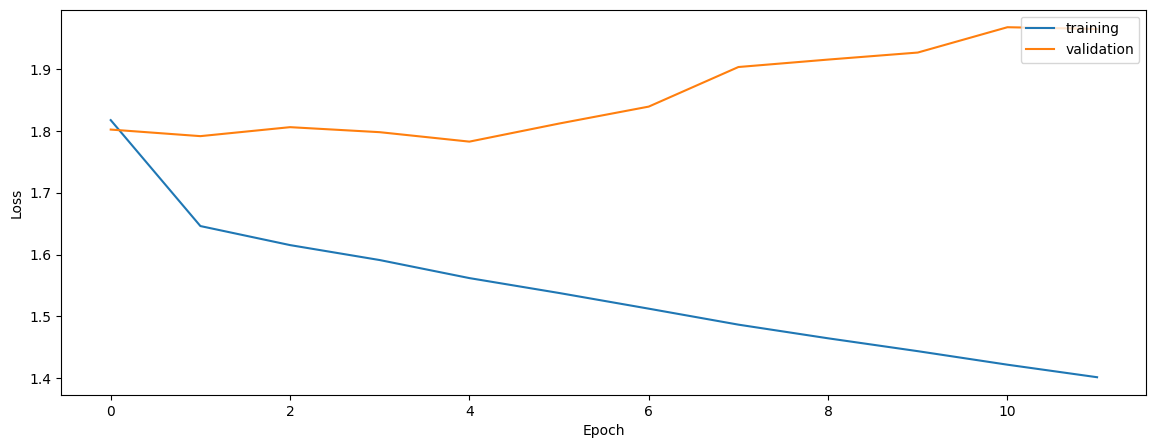

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.3832610194444012
0.32642789056059357
0.3664050798202604


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.40857422502097335
0.4000671618204804
0.40905873311220775


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.4060059052269571
0.3998375084631009
0.4092423856603523


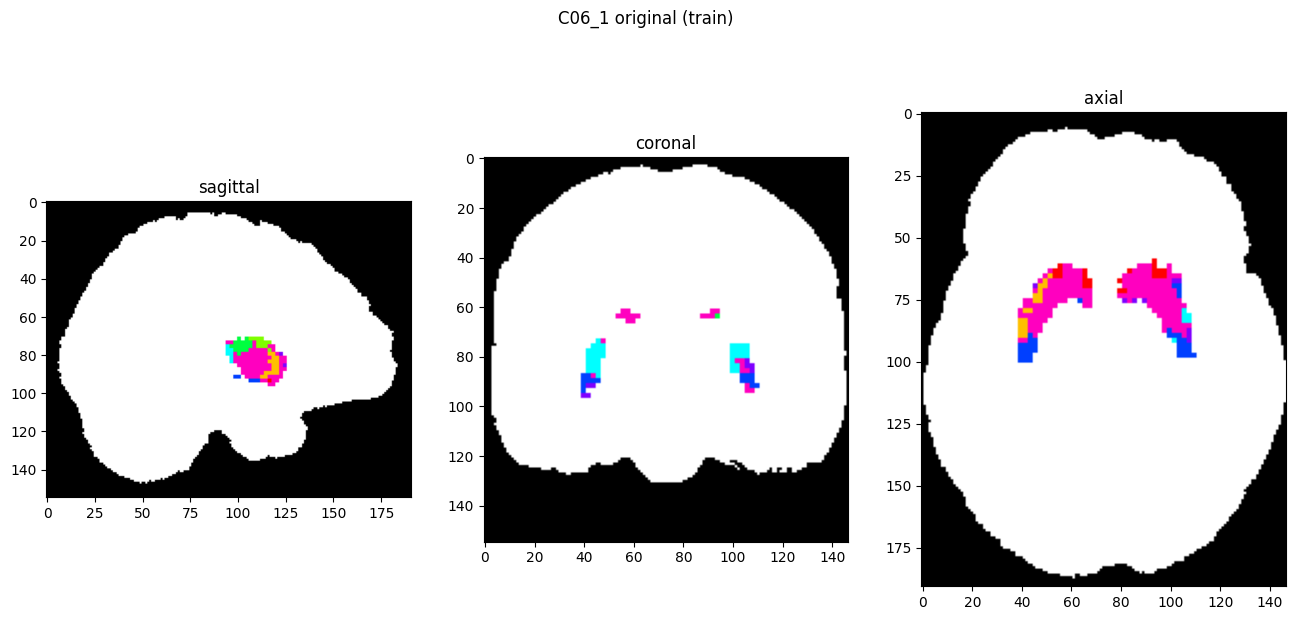

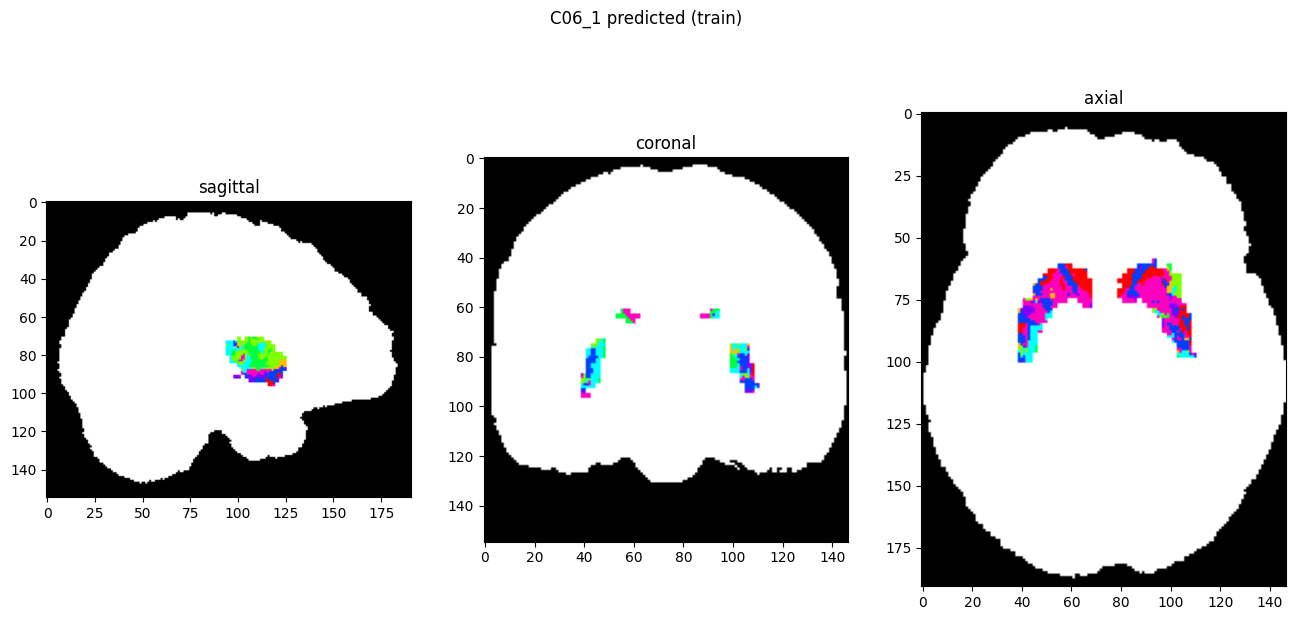

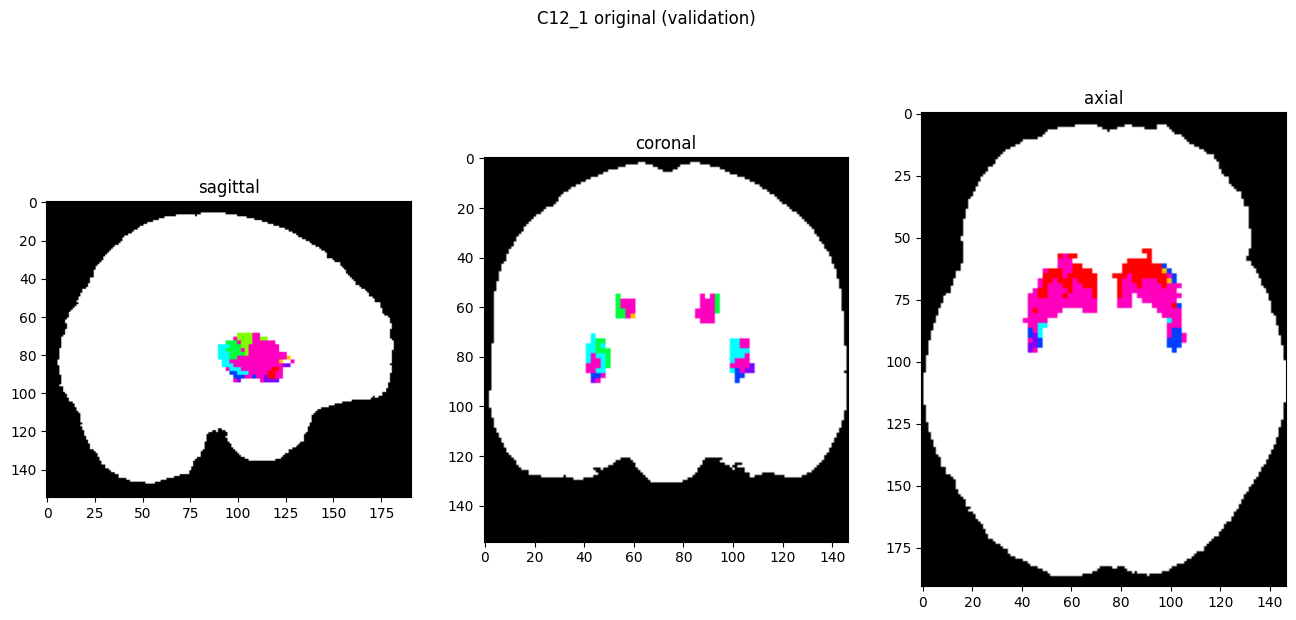

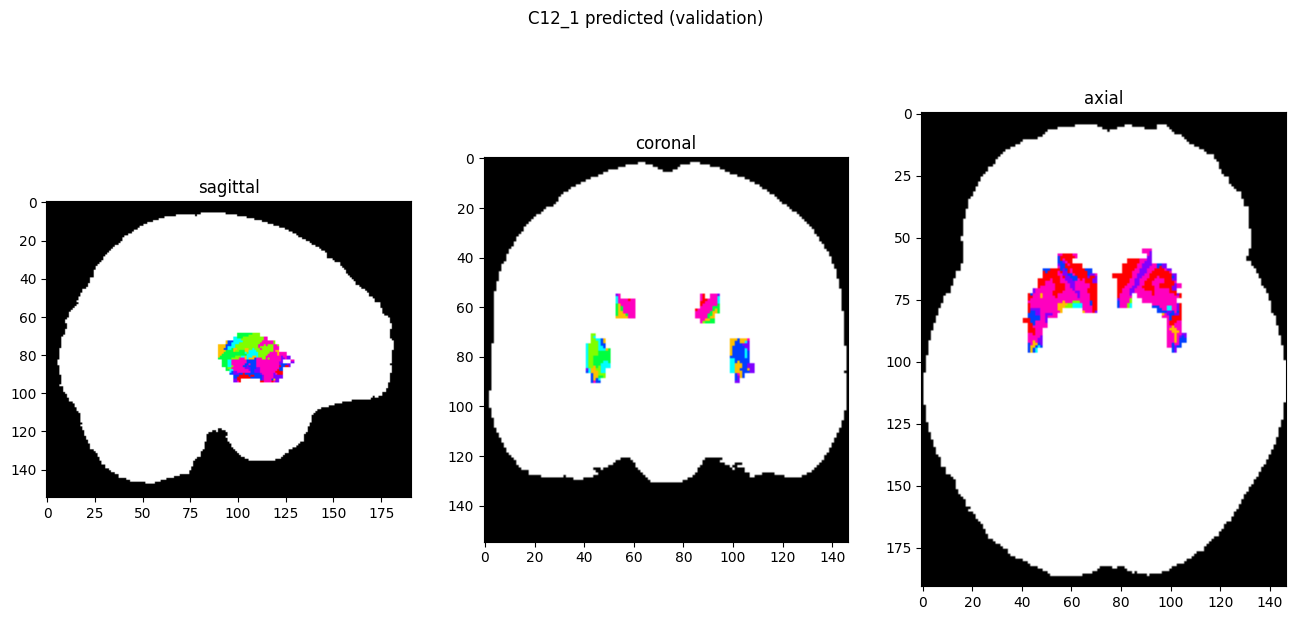

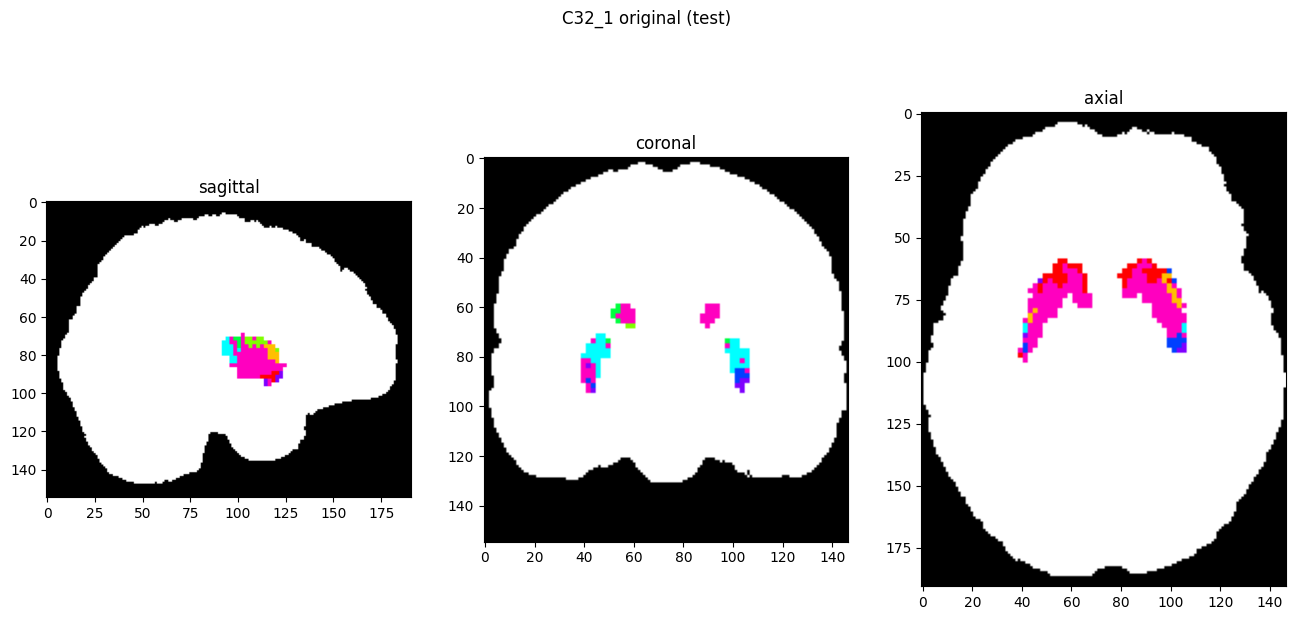

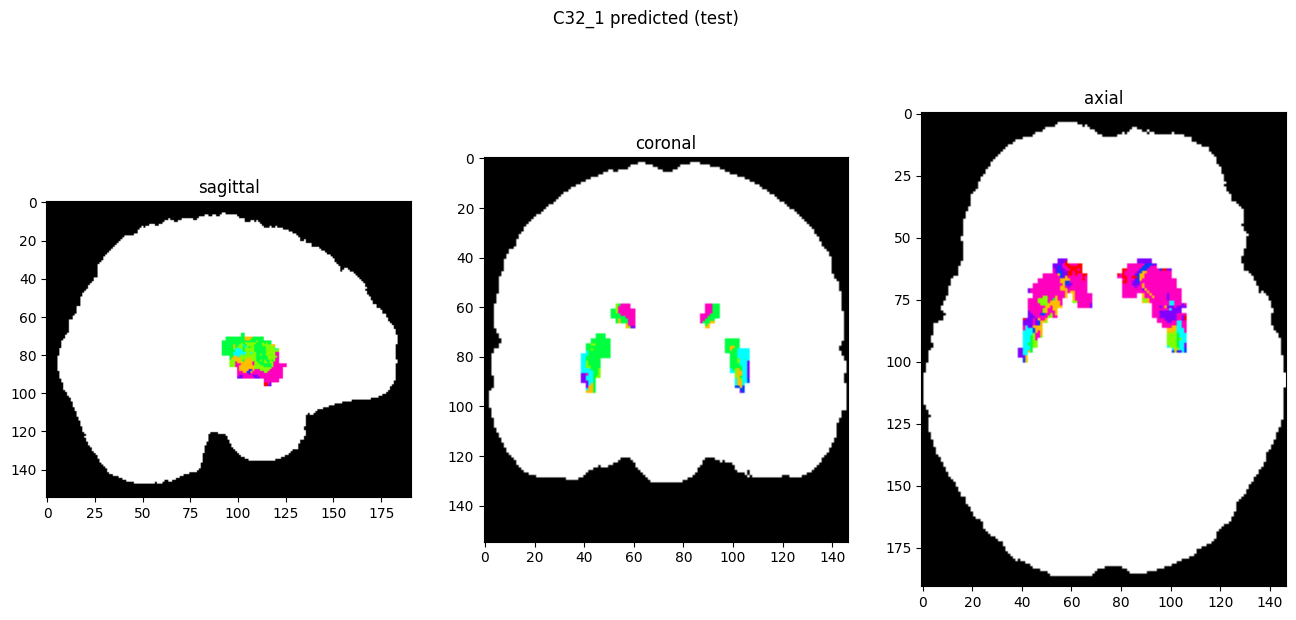

In [10]:
showResults(model, gen, threshold=0)